# INDEX:

1. [IMPORTS](#imports)
2. [CSV READING](#csv-reading)
3. [METADATA FEATURE CREATION](#metadata-feature-creation)
4. [DATA EXPLORATION](#data-exploration)
5. [FEATURE EXTRACTION](#feature-extraction)
6. [PRE-PROCESSING](#pre-processing)
    - 6.1 [CATEGORICAL VARIABLES HANDLING](#categorical-variables-handling)
    - 6.2 [CATEGORICAL VARIABLES ENCODING](#categorical-variables-encoding)
    - 6.3 [VITAL SIGNS HANDLING](#vital-signs-handling)
7. [PIPELINE PREPARATION](#pipeline-preparation)
8. [PIPELINES](#pipelines)
    - 8.1 [NN PIPELINE](#nn-pipeline)
    - 8.2 [ENSEMBLE PIPELINE](#ensemble-pipeline)

# IMPORTS

[Back to Index](#index)

In [537]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from category_encoders import BinaryEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix, roc_auc_score, mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, StackingRegressor
# from sklearn.ensemble import IsolationForest
# import missingno as msno
# from scipy.stats import chi2_contingency
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
import category_encoders as ce
import pickle
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, RegressorMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif
# from sklearn.neural_network import MLPClassifier, MLPRegressor
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import optimizers
from keras import initializers
import os
from tensorflow import exp
# import mlens
from mlens.ensemble import SuperLearner

[Back to Index](#index)

# CSV READING

[Back to Index](#index)

In [538]:
df_train = pd.read_csv('mimic_train.csv')
df_test = pd.read_csv('mimic_test_los.csv')

print(len(df_train['hadm_id'].unique()))

19749


In [539]:
display(df_train)
display(df_test)

target = 'LOS'

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,0,28043,135417,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,...,-60714.92678,EMERGENCY,Medicare,CATHOLIC,MARRIED,WHITE,ALTERED MENTAL STATUS,3229,MICU,11.6116
20881,0,87605,191007,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,...,-46217.77777,EMERGENCY,Private,NOT SPECIFIED,MARRIED,BLACK/HAITIAN,NEW BRAIN MASS,1918,SICU,1.1593
20882,0,47492,152608,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,...,-39830.10848,EMERGENCY,Private,PROTESTANT QUAKER,DIVORCED,BLACK/AFRICAN AMERICAN,HYPOGLYCEMIA,24980,MICU,1.8830
20883,0,62946,191485,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,...,-59205.26841,EMERGENCY,Medicare,PROTESTANT QUAKER,WIDOWED,WHITE,CORONARY ARTERY DISEASE\PERCUTANEOUS CORONARY ...,41401,CCU,3.1981


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,2196-02-23 11:45:00,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,2103-10-22 23:58:00,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,2115-06-28 07:15:00,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,2162-08-01 21:00:00,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,2103-01-16 22:05:00,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,28941,107962,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,...,2144-07-16 11:01:00,-49718.62088,EMERGENCY,Medicare,OTHER,SINGLE,WHITE,MEDIASTINAL MASS,20152,SICU
5217,27436,112243,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2143-03-28 10:45:00,-49300.08263,ELECTIVE,Medicare,PROTESTANT QUAKER,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,4241,CSRU
5218,44232,156430,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,...,2102-04-03 04:04:00,-33708.91976,EMERGENCY,Medicare,GREEK ORTHODOX,WIDOWED,WHITE - RUSSIAN,SMALL BOWEL OBSTRUCTION;SEPSIS,34839,MICU
5219,76544,148900,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,...,2138-05-19 07:15:00,-46198.14080,ELECTIVE,Medicare,CATHOLIC,DIVORCED,WHITE,CORONARY ARTERY DISEASE\AORTIC VALVE / ASCENDI...,41401,CSRU


In [540]:
metadata_df = pd.read_csv('./extra_data/MIMIC_diagnoses.csv')

display(metadata_df)
print(len(metadata_df['HADM_ID'].unique()))

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859
...,...,...,...,...
651042,65535,178280,5.0,5119
651043,65535,178280,6.0,5990
651044,65535,178280,7.0,0414
651045,65535,178280,8.0,25000


58976


In [541]:
id_cols = ['subject_id', 'hadm_id', 'icustay_id']

final_output_df = df_test.copy()

[Back to Index](#index)

# METADATA FEATURE CREATION

[Back to Index](#index)

In [542]:
"""
In this block I prepare the metadata as columns with the different codes that each hospital stay (hadm_id) has associated to it.
"""

comorbidities = metadata_df.groupby('HADM_ID').agg(
    DIAGNOSIS_COUNT=('ICD9_CODE', 'nunique'),  # Count of unique ICD9 codes
    ICD9_CODE_LIST=('ICD9_CODE', lambda x: list(x.unique()))  # List of unique ICD9 codes
).reset_index()

df_train = pd.merge(df_train, comorbidities, left_on='hadm_id', right_on='HADM_ID',how='left').drop(columns='HADM_ID')

df_test = pd.merge(df_test, comorbidities, left_on='hadm_id', right_on='HADM_ID',how='left').drop(columns='HADM_ID')

print(max(df_train['DIAGNOSIS_COUNT']))
print(df_train['DIAGNOSIS_COUNT'].describe())

target_encoder_cols = []

for i in range(1, 21):
    df_train[f'code{i}'] = df_train['ICD9_CODE_LIST'].apply(lambda x: x[i-1] if len(x) > i-1 else None)
    df_test[f'code{i}'] = df_test['ICD9_CODE_LIST'].apply(lambda x: x[i-1] if len(x) > i-1 else None)
    target_encoder_cols.append(f'code{i}')

cols_out_of_list = target_encoder_cols.copy()
cols_out_of_list.append('ICD9_CODE_LIST')

print(target_encoder_cols)
print(cols_out_of_list)

39
count    20885.000000
mean        14.836916
std          7.299555
min          1.000000
25%          9.000000
50%         14.000000
75%         19.000000
max         39.000000
Name: DIAGNOSIS_COUNT, dtype: float64
['code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20']
['code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20', 'ICD9_CODE_LIST']


[Back to Index](#index)

# DATA EXPLORATION

[Back to Index](#index)

In [543]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 66 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_Mean        

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5221 entries, 0 to 5220
Data columns (total 61 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   subject_id       5221 non-null   int64  
 1   hadm_id          5221 non-null   int64  
 2   icustay_id       5221 non-null   int64  
 3   HeartRate_Min    4676 non-null   float64
 4   HeartRate_Max    4676 non-null   float64
 5   HeartRate_Mean   4676 non-null   float64
 6   SysBP_Min        4670 non-null   float64
 7   SysBP_Max        4670 non-null   float64
 8   SysBP_Mean       4670 non-null   float64
 9   DiasBP_Min       4669 non-null   float64
 10  DiasBP_Max       4669 non-null   float64
 11  DiasBP_Mean      4669 non-null   float64
 12  MeanBP_Min       4674 non-null   float64
 13  MeanBP_Max       4674 non-null   float64
 14  MeanBP_Mean      4674 non-null   float64
 15  RespRate_Min     4675 non-null   float64
 16  RespRate_Max     4675 non-null   float64
 17  RespRate_Mean 

None

In [544]:
display(df_train[df_train['HeartRate_Mean'].isna() & df_train['SysBP_Mean'].isna()][['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean']].describe())
display(df_train[df_train['HeartRate_Mean'].isna() & df_train['SysBP_Mean'].isna()][['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean']].count())
display(df_test[df_test['HeartRate_Mean'].isna() & df_test['SysBP_Mean'].isna()][['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean']].describe())
display(df_test[df_test['HeartRate_Mean'].isna() & df_test['SysBP_Mean'].isna()][['HeartRate_Mean', 'SysBP_Mean', 'DiasBP_Mean', 'MeanBP_Mean', 'RespRate_Mean', 'TempC_Mean', 'SpO2_Mean', 'Glucose_Mean']].count())

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean
count,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2185.000000
mean,NaN,NaN,NaN,96.0,25.0,NaN,NaN,137.326731
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48.896984
min,NaN,NaN,NaN,96.0,25.0,NaN,NaN,42.000000
25%,NaN,NaN,NaN,96.0,25.0,NaN,NaN,109.000000
50%,NaN,NaN,NaN,96.0,25.0,NaN,NaN,126.750000
75%,NaN,NaN,NaN,96.0,25.0,NaN,NaN,152.000000
max,NaN,NaN,NaN,96.0,25.0,NaN,NaN,611.600000


HeartRate_Mean       0
SysBP_Mean           0
DiasBP_Mean          0
MeanBP_Mean          1
RespRate_Mean        1
TempC_Mean           0
SpO2_Mean            0
Glucose_Mean      2185
dtype: int64

,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,544.000000
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.444775
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.716870
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,108.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,127.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.312500
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,431.500000


HeartRate_Mean      0
SysBP_Mean          0
DiasBP_Mean         0
MeanBP_Mean         0
RespRate_Mean       0
TempC_Mean          0
SpO2_Mean           0
Glucose_Mean      544
dtype: int64

As we can observe, there are some observations which lack a good amount of observations. We are going to try removing those approx 2000 rows to see if our predictions improve. Imputing on every vital indicator might not be the best approach.

In [545]:
sum(df_train['ICD9_diagnosis'].value_counts() >= 10)

358

In [546]:
sum(df_train['DIAGNOSIS'].value_counts() > 10)

176

With the previous two blocks of code we can see how the diagnosis codes have a lot of different categories and most of them have quite a lot of observations each. As a result we cannot encode this variable in simple manners, we need something like target encoding.

[Back to Index](#index)

# FEATURE EXTRACTION

[Back to Index](#index)

In [547]:
df_train['ADMITTIME'] = pd.to_datetime(df_train['ADMITTIME'])
df_train['DOB'] = pd.to_datetime(df_train['DOB'])
df_test['ADMITTIME'] = pd.to_datetime(df_test['ADMITTIME'])
df_test['DOB'] = pd.to_datetime(df_test['DOB'])

df_train['ADMITTIME'] += pd.to_timedelta(df_train['Diff'], unit = 'D')
df_train['DOB'] += pd.to_timedelta(df_train['Diff'], unit = 'D')
df_test['ADMITTIME'] += pd.to_timedelta(df_test['Diff'], unit = 'D')
df_test['DOB'] += pd.to_timedelta(df_test['Diff'], unit = 'D')

#df_train['ADMIT_date'] = df_train['ADMITTIME'].dt.date
#df_train['DOB_date'] = df_train['DOB'].dt.date

print(df_train['ADMITTIME'].dt.year.value_counts())
print(df_train[df_train['DOB'].dt.year < 1900]['DOB'].dt.year.value_counts().sum())
print(df_train[df_train['DOB'].dt.year < 1900]['DOB'].dt.year.value_counts())

"""
We can safely determine that people over the age of 89 are assigned a DOB which is previous to 1900
That is because, as we can see below, the maximum age is still 89 when we compute it. 
If it wasn't like this, people who got assigned a year after 1900 would get an age older than 89
We can also safely assume that all of the people who were 89 when they entered the ICU are captured in the AGE and none of them gets any other age because the cutoff in 1900
would only leave out people who entered in 1989, and the first year covered by the observations is 2007.
"""

df_train.loc[df_train['DOB'].dt.year < 1900, 'DOB'] = np.nan
df_test.loc[df_test['DOB'].dt.year < 1900, 'DOB'] = np.nan

#display(df_train[['ADMITTIME', 'DOB']])

ADMITTIME
2008    5242
2009    4203
2010    4150
2011    4113
2012    3170
2007       7
Name: count, dtype: int64
1107
DOB
1708    286
1709    198
1710    175
1711    169
1712    133
1707     50
1702     24
1703     23
1706     18
1705     17
1704     11
1701      3
Name: count, dtype: int64


In [548]:
"""
Extraction of age when admitted to hospital.

The treatment of this variable is very delicate because being older than 89 is probably related to having more severe health issues but we don't have their real age. 
As we know that those people are older than 89 years old for sure, we will use an approximate average of 93,
so we will impute them an age that is between 90 and 100 but skewed towards 90 because not a lot of people live past 95 years old. 
This is completely arbitrary but the intent is just to try and capture the effect of being older than 89 while minimizing the effect on its estimate relevance.
If we set the age of people over 89 to 90 for all of them, probably the effect of those of them who are older than 92-93 (thus having a higher risk) would make a sudden 
jump in the effect of age on 89 to 90 years of age. As a result, the estimate of the effect of being 25 instead of 24 would also be overestimated. We are trying to prevent 
that in a simple way
"""

df_train['AGE'] = round((df_train['ADMITTIME'] - df_train['DOB']).dt.days / 365.25)
df_test['AGE'] = round((df_test['ADMITTIME'] - df_test['DOB']).dt.days / 365.25)

df_train.loc[df_train['AGE'].isna(), 'AGE'] = 93.0
df_test.loc[df_train['AGE'].isna(), 'AGE'] = 93.0

display(df_train['AGE'])
display(df_train['AGE'].describe())
display(df_test['AGE'].describe())


0        70.0
1        42.0
2        68.0
3        75.0
4        79.0
         ... 
20880    88.0
20881    66.0
20882    63.0
20883    93.0
20884    46.0
Name: AGE, Length: 20885, dtype: float64

count    20885.000000
mean        64.350347
std         17.381877
min         15.000000
25%         53.000000
50%         66.000000
75%         78.000000
max         93.000000
Name: AGE, dtype: float64

count    4951.000000
mean       63.273480
std        16.214719
min        15.000000
25%        53.000000
50%        65.000000
75%        76.000000
max        89.000000
Name: AGE, dtype: float64

In [549]:
"""
Extraction of the hour of the day when admitted to hospital as an integer value
"""

df_train['ADMIT_HOUR'] = df_train['ADMITTIME'].dt.hour
df_test['ADMIT_HOUR'] = df_test['ADMITTIME'].dt.hour

In [550]:
"""
Extraction of Number of previous ICU stays per patient
"""

df_train_count = df_train[['subject_id', 'ADMITTIME', 'icustay_id']].copy()
df_test_count = df_test[['subject_id', 'ADMITTIME', 'icustay_id']].copy()

df_train_count = df_train_count.sort_values(by = ['subject_id', 'ADMITTIME'])
df_test_count = df_test_count.sort_values(by = ['subject_id', 'ADMITTIME'])

df_train_count['previous_icu_stays'] = df_train_count.groupby('subject_id').cumcount()
df_test_count['previous_icu_stays'] = df_test_count.groupby('subject_id').cumcount()

df_train = pd.merge(df_train, df_train_count[['icustay_id', 'previous_icu_stays']], on = 'icustay_id', how = 'left')
df_test = pd.merge(df_test, df_test_count[['icustay_id', 'previous_icu_stays']], on = 'icustay_id', how = 'left')

#print(df_train['previous_icu_stays'].describe(), df_test_count['previous_icu_stays'].describe())

print(df_train[df_train['previous_icu_stays'] > 0]['previous_icu_stays'].count())

4568


In [551]:
display(df_train)
display(df_test)

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,code14,code15,code16,code17,code18,code19,code20,AGE,ADMIT_HOUR,previous_icu_stays
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,5852,43811,43889,78079,None,None,None,70.0,15,0
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,None,None,None,None,None,None,None,42.0,18,0
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,4465,None,None,None,None,None,None,68.0,23,0
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,...,V4364,V4365,None,None,None,None,None,75.0,22,0
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,...,496,2449,V1011,None,None,None,None,79.0,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,0,28043,135417,244530,65.0,92.0,78.500000,60.0,160.0,110.976190,...,28529,2767,25000,70703,70720,3530,7292,88.0,8,2
20881,0,87605,191007,216116,74.0,112.0,89.156250,100.0,150.0,123.272727,...,None,None,None,None,None,None,None,66.0,4,1
20882,0,47492,152608,274507,58.0,97.0,76.933333,94.0,131.0,112.037037,...,None,None,None,None,None,None,None,63.0,15,0
20883,0,62946,191485,225930,59.0,102.0,81.844444,96.0,150.0,123.837209,...,None,None,None,None,None,None,None,93.0,14,0


,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,code14,code15,code16,code17,code18,code19,code20,AGE,ADMIT_HOUR,previous_icu_stays
0,64058,146725,208169,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,...,4019,2724,3899,71590,56400,V1582,V707,82.0,1,0
1,55871,108789,251754,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,...,None,None,None,None,None,None,None,48.0,21,0
2,42892,139885,242171,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,...,None,None,None,None,None,None,None,42.0,16,1
3,66629,173017,263035,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,...,53081,311,V4364,None,None,None,None,84.0,7,0
4,79851,171573,279388,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,...,99799,4168,42731,V462,41400,V4581,V433,53.0,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,28941,107962,278087,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,...,20158,319,42731,05410,42789,E9420,04185,59.0,20,0
5217,27436,112243,266914,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42731,V667,4019,2724,4280,V6441,V4582,76.0,8,0
5218,44232,156430,213413,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,...,None,None,None,None,None,None,None,81.0,5,1
5219,76544,148900,286384,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,...,None,None,None,None,None,None,None,79.0,3,0


[Back to Index](#index)

# PRE-PROCESSING

[Back to Index](#index)

In [552]:
"""
We drop the columns that are not useful for the processing anymore.
"""

cols_to_drop = ['subject_id',
                'hadm_id',
                'icustay_id',
                'DOD',
                'DISCHTIME',
                'DEATHTIME',
                'HOSPITAL_EXPIRE_FLAG',
                'Diff',
                'ADMITTIME',
                'DOB',
                'ICD9_CODE_LIST',
                'DIAGNOSIS',
                'ICD9_diagnosis'
                ]

for col in cols_to_drop:
    if col in df_train.columns:
        df_train.drop(col, axis = 1, inplace = True)
    else:
        pass
    
    if col in df_test.columns:
        df_test.drop(col, axis = 1, inplace = True)
    else:
        pass

In [553]:
"""
I define and use the function to create lists with the numerical and categorical variables at any given time.
I am going to use it throughout the whole notebook to keep track of the variables and their types.
"""

def get_num_cat_cols():
    n_cols = df_test.select_dtypes(include = ['number']).columns.tolist()
    c_cols = df_test.select_dtypes(include = ['object']).columns.tolist()
    
    return n_cols, c_cols

num_cols, cat_cols = get_num_cat_cols()

print(num_cols)
print(cat_cols)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS_COUNT', 'AGE', 'ADMIT_HOUR', 'previous_icu_stays']
['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20']


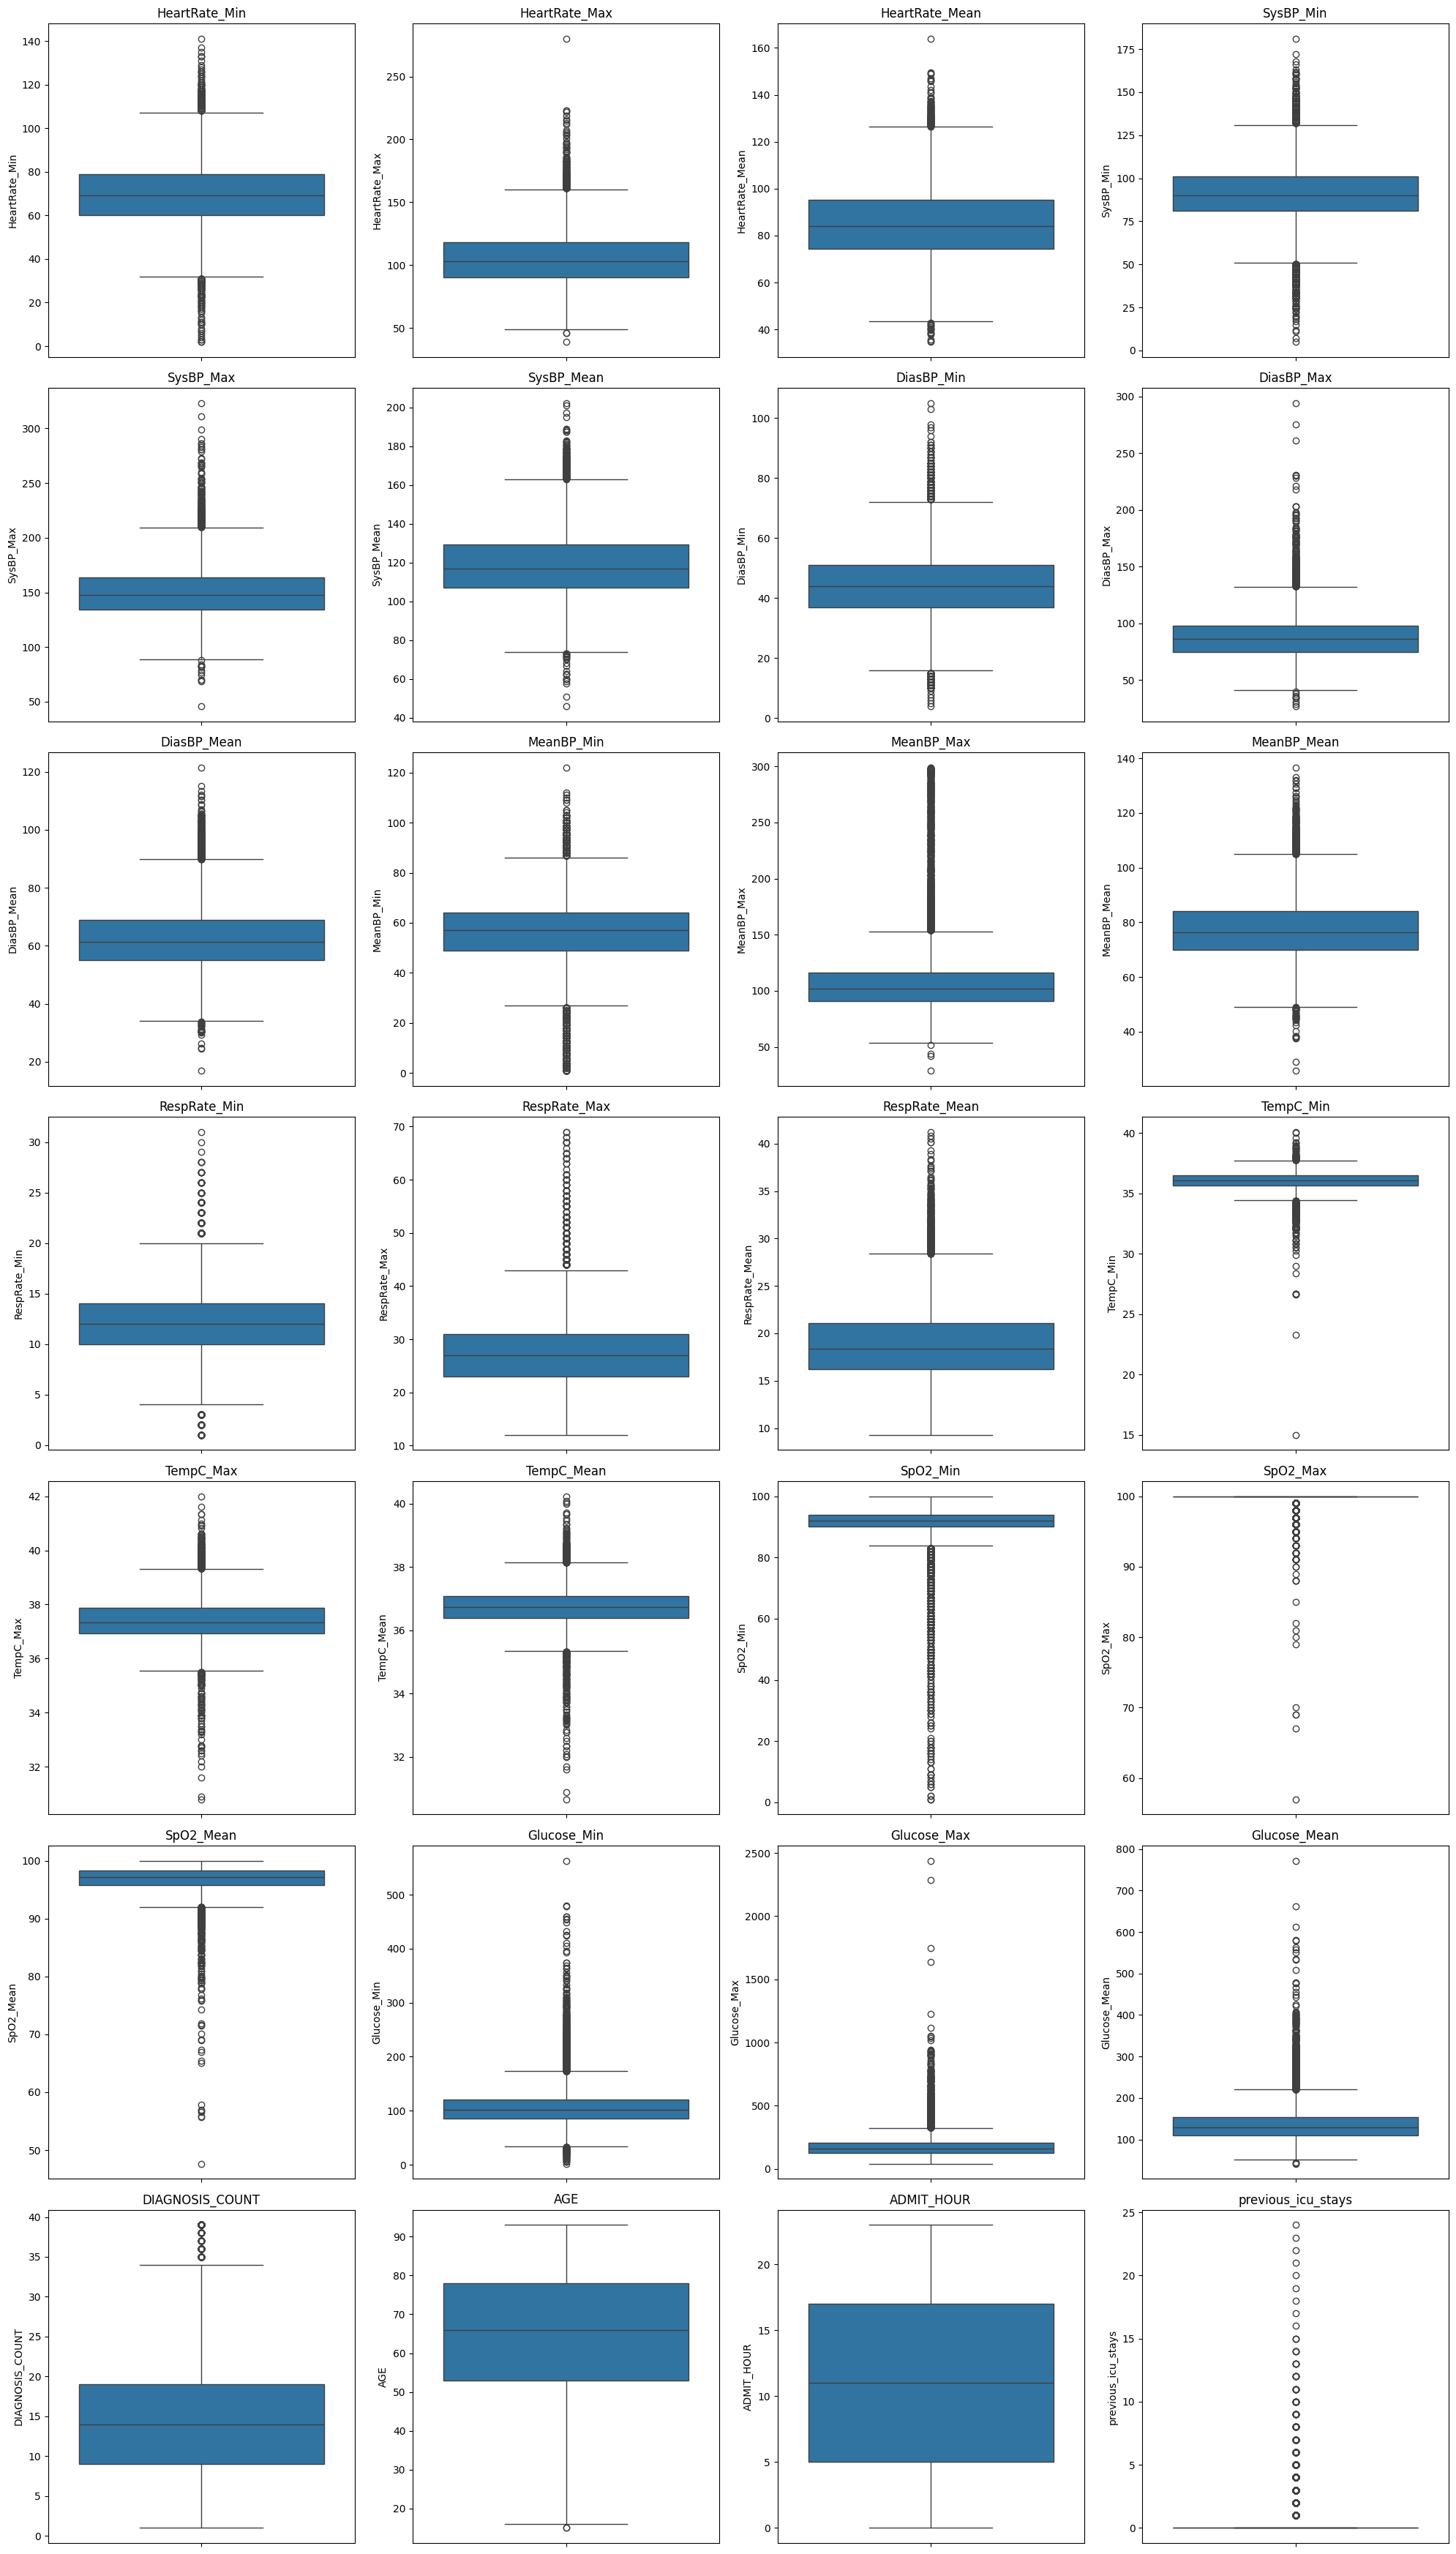

In [554]:
"""
We plot the distribution of the numerical variables to see if there are any outliers
and also to see if the distribution is skewed.
Aftwerwards we'll decide which columns to transform logarithmically before standardizing.
"""

plots_per_row = 4
num_rows = (len(num_cols) + plots_per_row - 1) // plots_per_row
plt.figure(figsize = (plots_per_row * 5, num_rows * 5))

plot_num = 1
for col in num_cols:
    plt.subplot(num_rows, plots_per_row, plot_num)
    sns.boxplot(y = df_train[col])
    plt.title(col)
    plot_num += 1

plt.tight_layout()
plt.show()

In [555]:
"""
After inspection of the post-log transformation boxplots, we see that those values can be removed as clear outliers.
"""

print(sum(df_train['TempC_Min'] < 25))
print(sum(df_test['TempC_Min'] < 25))
df_train.loc[df_train['TempC_Min'] < 25, 'TempC_Min'] = np.nan
df_test.loc[df_test['TempC_Min'] < 25, 'TempC_Min'] = np.nan

df_train.loc[df_train['HeartRate_Max'] > 250, 'HeartRate_Max'] = np.nan
df_test.loc[df_test['HeartRate_Max'] > 250, 'HeartRate_Max'] = np.nan

2
1


In [556]:
"""
The boxplots below will show the reason for the following block. Also justification below, mainly medical reasons.

'A normal level of oxygen is usually 95% or higher.'
"""

df_train['SpO2_low'] = np.where(df_train['SpO2_Mean'] < 95, 1, 0)
df_test['SpO2_low'] = np.where(df_test['SpO2_Mean'] < 95, 1, 0)

print(df_train['SpO2_low'].value_counts())
print(df_test['SpO2_low'].value_counts())

SpO2_low
0    18205
1     2680
Name: count, dtype: int64
SpO2_low
0    4581
1     640
Name: count, dtype: int64


In [557]:
"""
After inspecting the boxplot for 'previous_icu_stays', we see that the positive values would all be considered outliers. As such, I decided to transform the variable into a binary one.
"""

df_train['prev_icu_dummy'] = np.where(df_train['previous_icu_stays'] == 0, 0, 1)
df_test['prev_icu_dummy'] = np.where(df_test['previous_icu_stays'] == 0, 0, 1)

# display(df_train)
# display(df_test)

df_train.drop('previous_icu_stays', axis = 1, inplace = True)
df_test.drop('previous_icu_stays', axis = 1, inplace = True)

# display(df_train)
# display(df_test)

display(df_train['prev_icu_dummy'].value_counts())
display(df_test['prev_icu_dummy'].value_counts())

prev_icu_dummy
0    16317
1     4568
Name: count, dtype: int64

prev_icu_dummy
0    4847
1     374
Name: count, dtype: int64

In [558]:
"""
After a little bit of thought and looking at the boxplot, I decided to try to transform AGE by binning.

After running a first round, we observe that there are no patients with age less than 14, so we could eliminate
the child category. We are going to leave it just because it causes no harm. If it was a problem, we would
definitely eliminate it, though.
"""

def categorize_age(row):
    if row['AGE'] < 14:
        return 'child'
    elif row['AGE'] < 21:
        return 'young'
    elif row['AGE'] < 35:
        return 'young adult'
    elif row['AGE'] < 50:
        return 'adult'
    elif row['AGE'] < 65:
        return 'middle aged'
    elif row['AGE'] < 75:
        return 'senior'
    elif row['AGE'] < 85:
        return 'old'
    else:
        return 'elderly'

df_train['AGE'] = df_train.apply(categorize_age, axis = 1)
df_test['AGE'] = df_test.apply(categorize_age, axis = 1)

display(df_train['AGE'].value_counts())
display(df_train)

AGE
middle aged    5924
senior         4315
old            4131
adult          2581
elderly        2529
young adult    1251
young           154
Name: count, dtype: int64

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,code15,code16,code17,code18,code19,code20,AGE,ADMIT_HOUR,SpO2_low,prev_icu_dummy
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,...,43811,43889,78079,None,None,None,senior,15,0,0
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,...,None,None,None,None,None,None,adult,18,0,0
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,...,None,None,None,None,None,None,senior,23,0,0
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,...,V4365,None,None,None,None,None,old,22,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2449,V1011,None,None,None,None,old,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,94.0,56.595238,41.0,...,2767,25000,70703,70720,3530,7292,elderly,8,0,1
20881,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,83.0,67.818182,74.0,...,None,None,None,None,None,None,senior,4,0,1
20882,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,83.0,67.370370,66.0,...,None,None,None,None,None,None,middle aged,15,0,0
20883,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,85.0,60.232558,65.0,...,None,None,None,None,None,None,elderly,14,0,0


In [559]:
num_cols, cat_cols = get_num_cat_cols()

print(num_cols)
print(cat_cols)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS_COUNT', 'ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy']
['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'code17', 'code18', 'code19', 'code20', 'AGE']


In [560]:
"""
First we will try without turning outliers into NaNs to see how it goes.
Only at the end we will turn outliers into NaNs to compare.

In the end, as the numerical values were grouped together already and the results were already quite satisfactory, the test with basic outlier treatment didn't improve the final score and, actually, it worsened it.
As such, I decided not to pursue this approach further.
"""

"""
for col in num_cols:
    iqr = df_train[col].quantile(0.75) - df_train[col].quantile(0.25)
    
    df_train.loc[df_train[col] > df_train[col].quantile(0.75) + 1.5 * iqr, col] = np.nan
    df_train.loc[df_train[col] < df_train[col].quantile(0.25) - 1.5 * iqr, col] = np.nan
    
    df_test.loc[df_test[col] > df_train[col].quantile(0.75) + 1.5 * iqr, col] = np.nan
    df_test.loc[df_test[col] < df_train[col].quantile(0.25) - 1.5 * iqr, col] = np.nan
"""

'\nfor col in num_cols:\n    iqr = df_train[col].quantile(0.75) - df_train[col].quantile(0.25)\n    \n    df_train.loc[df_train[col] > df_train[col].quantile(0.75) + 1.5 * iqr, col] = np.nan\n    df_train.loc[df_train[col] < df_train[col].quantile(0.25) - 1.5 * iqr, col] = np.nan\n    \n    df_test.loc[df_test[col] > df_train[col].quantile(0.75) + 1.5 * iqr, col] = np.nan\n    df_test.loc[df_test[col] < df_train[col].quantile(0.25) - 1.5 * iqr, col] = np.nan\n'

In [561]:
for var in num_cols:
    print(f"\n{var}: {df_train[var].skew()}")


HeartRate_Min: 0.20057308586074962

HeartRate_Max: 0.6363849891111459

HeartRate_Mean: 0.33219582601432673

SysBP_Min: 0.11742821323772698

SysBP_Max: 0.7288485890434524

SysBP_Mean: 0.5616204192671789

DiasBP_Min: 0.19460894637806067

DiasBP_Max: 1.2567927012466218

DiasBP_Mean: 0.6028215741220705

MeanBP_Min: -0.6032591448353352

MeanBP_Max: 3.0910700899256267

MeanBP_Mean: 0.6066905259905032

RespRate_Min: 0.2572323068565508

RespRate_Max: 1.2445703356980082

RespRate_Mean: 0.928513696096776

TempC_Min: -1.6029256650361021

TempC_Max: 0.27324166942473044

TempC_Mean: -0.44308016780277154

SpO2_Min: -5.0031113983376745

SpO2_Max: -9.698138761040042

SpO2_Mean: -4.55208219200001

Glucose_Min: 2.045072888339506

Glucose_Max: 4.0581142576713125

Glucose_Mean: 2.20793071446498

DIAGNOSIS_COUNT: 0.7679950042515428

ADMIT_HOUR: -0.0033442656199790173

SpO2_low: 2.222798340046734

prev_icu_dummy: 1.360971068276855


In [562]:
cols_to_log = [col for col in num_cols if abs(df_train[col].skew()) > 1]

print(cols_to_log)

cols_to_delog = ['AGE', 'prev_icu_dummy', 'SpO2_low']

cols_to_log = [col for col in cols_to_log if col not in cols_to_delog]

for col in cols_to_log:
    print(f"{col}")

['DiasBP_Max', 'MeanBP_Max', 'RespRate_Max', 'TempC_Min', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'SpO2_low', 'prev_icu_dummy']
DiasBP_Max
MeanBP_Max
RespRate_Max
TempC_Min
SpO2_Min
SpO2_Max
SpO2_Mean
Glucose_Min
Glucose_Max
Glucose_Mean


In [563]:
for col in cols_to_log:
    df_train[col] = np.log1p(df_train[col])
    df_test[col] = np.log1p(df_test[col])

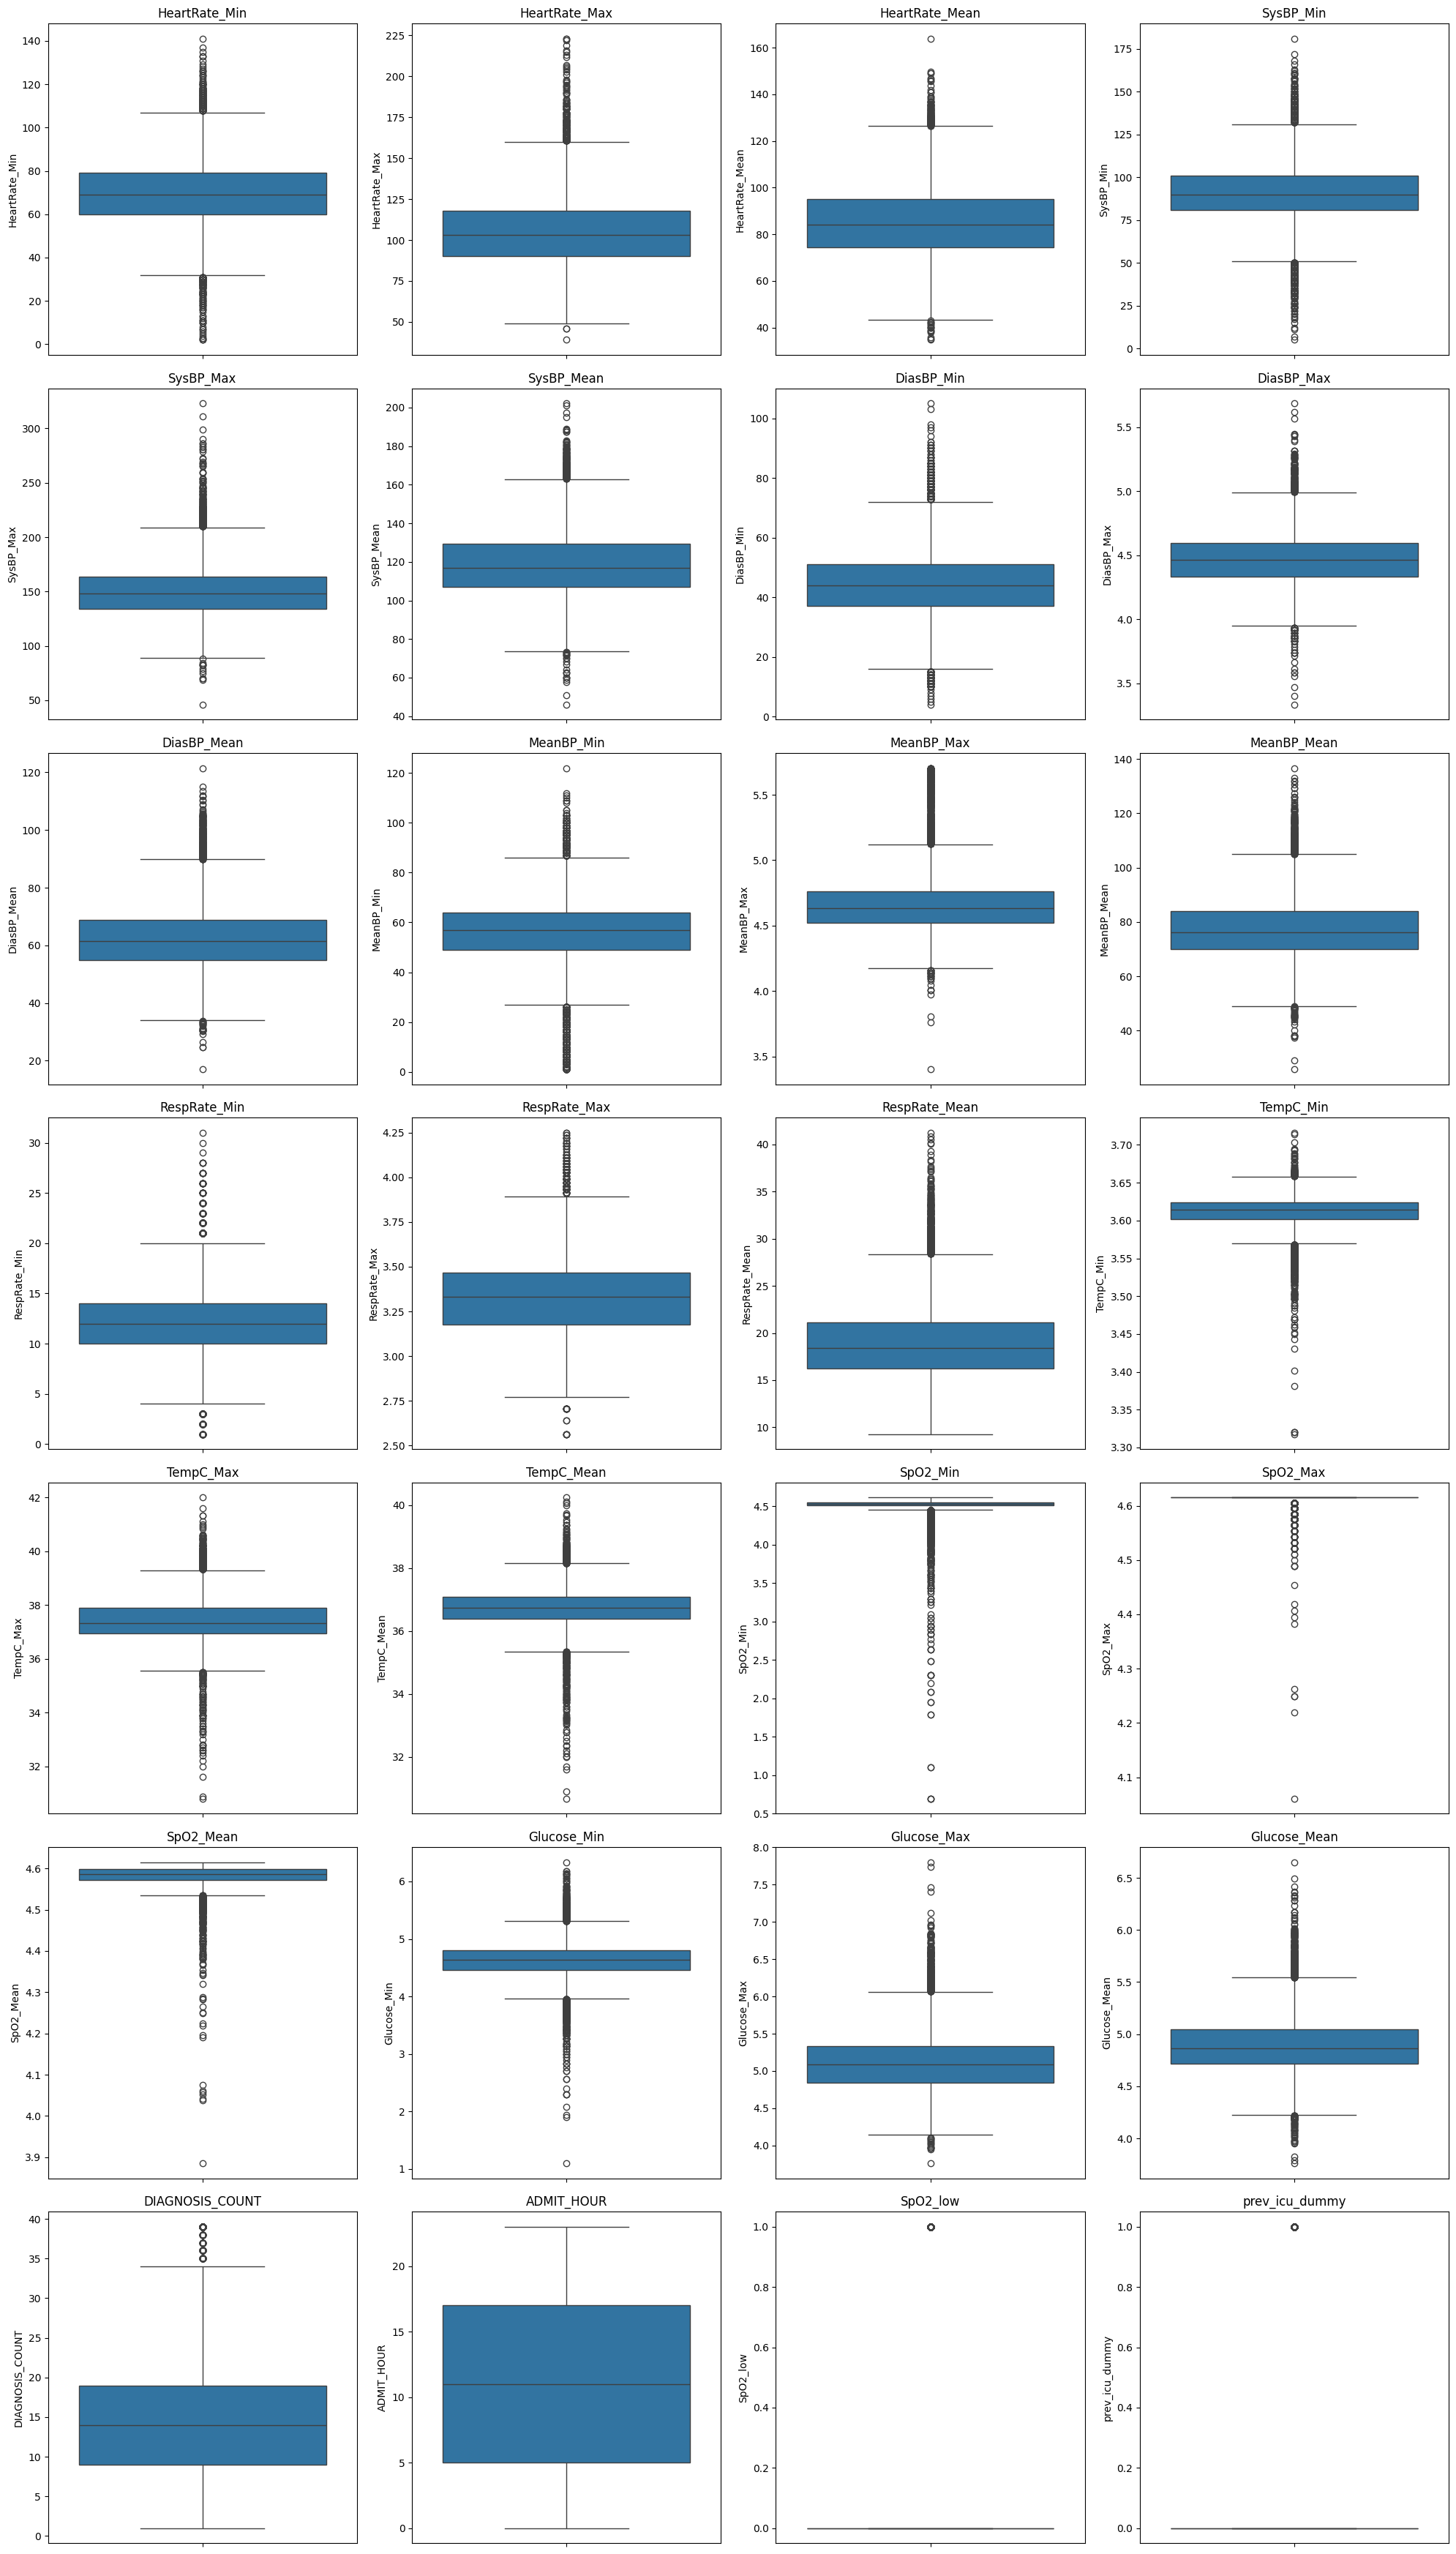

In [564]:
plots_per_row = 4
num_rows = (len(num_cols) + plots_per_row - 1) // plots_per_row
plt.figure(figsize = (plots_per_row * 5, num_rows * 5))

plot_num = 1
for col in num_cols:
    plt.subplot(num_rows, plots_per_row, plot_num)
    sns.boxplot(y = df_train[col])
    plt.title(col)
    plot_num += 1

plt.tight_layout()
plt.show()

In [565]:
"""
Upon inspection of this resulting plot, I have the hunch that SpO2 is not normally distributed.
And more so, it seems that a low SpO2 could be indicator of something ghastly.

A quick check on the internet confirmst it:
'For a healthy individual, the normal SpO2 should be between 96% to 99%. 
High altitudes and other factors may affect what is considered normal for a given individual.'

'Anything below 95% is considered low and may put you at risk of hypoxemia.'

As a result, we will go back up to the levels over 100% and create a dummy variable for it.
Then we will drop the original variables.
"""

df_train.drop(['SpO2_Mean', 'SpO2_Min', 'SpO2_Max'], axis = 1, inplace = True)
df_test.drop(['SpO2_Mean', 'SpO2_Min', 'SpO2_Max'], axis = 1, inplace = True)

## CATEGORICAL VARIABLES HANDLING

[Back to Index](#index)

In [566]:
num_cols, cat_cols = get_num_cat_cols()

cat_cols = [c for c in cat_cols if c not in cols_out_of_list]

print(num_cols)
print(cat_cols)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS_COUNT', 'ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy']
['GENDER', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'FIRST_CAREUNIT', 'AGE']


In [567]:
for col in cat_cols:
    print(df_train[col].value_counts())
    print('\n')

print(len(cat_cols))

GENDER
M    11759
F     9126
Name: count, dtype: int64


ADMISSION_TYPE
EMERGENCY    17817
ELECTIVE      2848
URGENT         220
Name: count, dtype: int64


INSURANCE
Medicare      11718
Private        6245
Medicaid       2117
Government      611
Self Pay        194
Name: count, dtype: int64


RELIGION
CATHOLIC                  7655
NOT SPECIFIED             5398
PROTESTANT QUAKER         2753
JEWISH                    1840
UNOBTAINABLE              1515
OTHER                      702
EPISCOPALIAN               288
GREEK ORTHODOX             178
CHRISTIAN SCIENTIST        164
BUDDHIST                   109
MUSLIM                      74
UNITARIAN-UNIVERSALIST      54
JEHOVAH'S WITNESS           45
ROMANIAN EAST. ORTH         41
HINDU                       38
7TH DAY ADVENTIST           30
HEBREW                       1
Name: count, dtype: int64


MARITAL_STATUS
MARRIED              9664
SINGLE               5910
WIDOWED              2819
DIVORCED             1413
SEPARATED             

In [568]:
cols_OH = [
    'FIRST_CAREUNIT',
    'MARITAL_STATUS',
    'ETHNICITY',
    'INSURANCE',
    'ADMISSION_TYPE',
    'GENDER',
    'AGE'
]

cols_binary = [
    'RELIGION'
]

"""
Coming from below, we also already create a list with the most frequent categories for each variable in order to drop them below.
"""
most_frequent_categories = [df_train[col].mode()[0] for col in cat_cols]
print(most_frequent_categories)

['M', 'EMERGENCY', 'Medicare', 'CATHOLIC', 'MARRIED', 'WHITE', 'MICU', 'middle aged']


In [569]:
"""
First of all we will turn the 'hebrew' religion into 'other' as there is only 1 observation.
"""

df_train.loc[df_train['RELIGION'] == 'HEBREW', 'RELIGION'] = 'OTHER'
df_test.loc[df_test['RELIGION'] == 'HEBREW', 'RELIGION'] = 'OTHER'

In [570]:
"""
In the beginning, we were able to see how from those categorical columns, the only one with missing values
is the marital status. As it is stated that UNKNOWN is the default, we will set the NA to that value.
"""

df_train.loc[df_train['MARITAL_STATUS'].isna(), 'MARITAL_STATUS'] = 'UNKNOWN'
df_train.loc[df_train['MARITAL_STATUS'] == 'UNKNOWN (DEFAULT)', 'MARITAL_STATUS'] = 'UNKNOWN'
df_test.loc[df_test['MARITAL_STATUS'].isna(), 'MARITAL_STATUS'] = 'UNKNOWN'
df_test.loc[df_test['MARITAL_STATUS'] == 'UNKNOWN (DEFAULT)', 'MARITAL_STATUS'] = 'UNKNOWN'

display(df_train['MARITAL_STATUS'].value_counts())
display(df_test['MARITAL_STATUS'].value_counts())

MARITAL_STATUS
MARRIED         9664
SINGLE          5910
WIDOWED         2819
DIVORCED        1413
UNKNOWN          825
SEPARATED        240
LIFE PARTNER      14
Name: count, dtype: int64

MARITAL_STATUS
MARRIED         2461
SINGLE          1438
WIDOWED          709
DIVORCED         353
UNKNOWN          208
SEPARATED         51
LIFE PARTNER       1
Name: count, dtype: int64

In [571]:
"""
In order to simplify the ETHNICITY column we will reduce the amount of details in each cell.
We are trying to minimize the added dimensionality after encoding.
Taking a look at the previous values, we can reduce it even further by sheer logic:
- We set portuguese to 'white' as portuguese people are standard caucasian white in general
- We set 'unable to obtain', 'unknown', 'patient declined' and 'multi race' to 'unknown'
- We set 'middle' back to 'middle eastern'
- We set 'native' to 'hawaiian'
- We set 'american' to 'american indian' to avoid confusion
- We set 'south' american to 'hispanic'

After a first inspection, we will be turning hawaiian and caribbean to other, as they only appear 6 times each in the training dataset.
"""

df_train['ETHNICITY'] = df_train['ETHNICITY'].str.extract(r"^(\w+)")

df_train.loc[df_train['ETHNICITY'] == 'UNABLE', 'ETHNICITY'] = 'UNKNOWN'
df_train.loc[df_train['ETHNICITY'] == 'PORTUGUESE', 'ETHNICITY'] = 'WHITE'
df_train.loc[df_train['ETHNICITY'] == 'PATIENT', 'ETHNICITY'] = 'UNKNOWN'
df_train.loc[df_train['ETHNICITY'] == 'MULTI', 'ETHNICITY'] = 'UNKNOWN'
df_train.loc[df_train['ETHNICITY'] == 'MIDDLE', 'ETHNICITY'] = 'MIDDLE EASTERN'
df_train.loc[df_train['ETHNICITY'] == 'NATIVE', 'ETHNICITY'] = 'OTHER'
df_train.loc[df_train['ETHNICITY'] == 'AMERICAN', 'ETHNICITY'] = 'AMERICAN INDIAN'
df_train.loc[df_train['ETHNICITY'] == 'SOUTH', 'ETHNICITY'] = 'HISPANIC'
df_train.loc[df_train['ETHNICITY'] == 'CARIBBEAN', 'ETHNICITY'] = 'OTHER'


df_test['ETHNICITY'] = df_test['ETHNICITY'].str.extract(r"^(\w+)")

df_test.loc[df_test['ETHNICITY'] == 'UNABLE', 'ETHNICITY'] = 'UNKNOWN'
df_test.loc[df_test['ETHNICITY'] == 'PORTUGUESE', 'ETHNICITY'] = 'WHITE'
df_test.loc[df_test['ETHNICITY'] == 'PATIENT', 'ETHNICITY'] = 'UNKNOWN'
df_test.loc[df_test['ETHNICITY'] == 'MULTI', 'ETHNICITY'] = 'UNKNOWN'
df_test.loc[df_test['ETHNICITY'] == 'MIDDLE', 'ETHNICITY'] = 'MIDDLE EASTERN'
df_test.loc[df_test['ETHNICITY'] == 'NATIVE', 'ETHNICITY'] = 'OTHER'
df_test.loc[df_test['ETHNICITY'] == 'AMERICAN', 'ETHNICITY'] = 'AMERICAN INDIAN'
df_test.loc[df_test['ETHNICITY'] == 'SOUTH', 'ETHNICITY'] = 'HISPANIC'
df_test.loc[df_test['ETHNICITY'] == 'CARIBBEAN', 'ETHNICITY'] = 'OTHER'


#display(df_train)
print(df_train['ETHNICITY'].value_counts())
print(f"\n{df_test['ETHNICITY'].value_counts()}")


display(df_train)
#display(df_test)

ETHNICITY
WHITE              15370
BLACK               2201
UNKNOWN             1370
HISPANIC             859
ASIAN                545
OTHER                501
MIDDLE EASTERN        24
AMERICAN INDIAN       15
Name: count, dtype: int64

ETHNICITY
WHITE              3866
BLACK               532
UNKNOWN             364
HISPANIC            203
ASIAN               144
OTHER               103
MIDDLE EASTERN        8
AMERICAN INDIAN       1
Name: count, dtype: int64


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,code15,code16,code17,code18,code19,code20,AGE,ADMIT_HOUR,SpO2_low,prev_icu_dummy
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,4.510860,61.173913,59.0,...,43811,43889,78079,None,None,None,senior,15,0,0
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,4.317488,64.733333,58.0,...,None,None,None,None,None,None,adult,18,0,0
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,4.219508,56.821429,64.0,...,None,None,None,None,None,None,senior,23,0,0
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,4.499810,41.864865,48.0,...,V4365,None,None,None,None,None,old,22,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2449,V1011,None,None,None,None,old,7,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,4.553877,56.595238,41.0,...,2767,25000,70703,70720,3530,7292,elderly,8,0,1
20881,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,4.430817,67.818182,74.0,...,None,None,None,None,None,None,senior,4,0,1
20882,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,4.430817,67.370370,66.0,...,None,None,None,None,None,None,middle aged,15,0,0
20883,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,4.454347,60.232558,65.0,...,None,None,None,None,None,None,elderly,14,0,0


## CATEGORICAL VARIABLES ENCODING

[Back to Index](#index)

In [572]:
"""
I apply the different encoders to the different variables we want to encode to remove categorical values.
"""

'\nI apply the different encoders to the different variables we want to encode to remove categorical values.\n'

In [573]:
display(df_train.info())
display(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 54 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HeartRate_Min    18698 non-null  float64
 1   HeartRate_Max    18697 non-null  float64
 2   HeartRate_Mean   18698 non-null  float64
 3   SysBP_Min        18677 non-null  float64
 4   SysBP_Max        18677 non-null  float64
 5   SysBP_Mean       18677 non-null  float64
 6   DiasBP_Min       18676 non-null  float64
 7   DiasBP_Max       18676 non-null  float64
 8   DiasBP_Mean      18676 non-null  float64
 9   MeanBP_Min       18699 non-null  float64
 10  MeanBP_Max       18699 non-null  float64
 11  MeanBP_Mean      18699 non-null  float64
 12  RespRate_Min     18696 non-null  float64
 13  RespRate_Max     18696 non-null  float64
 14  RespRate_Mean    18696 non-null  float64
 15  TempC_Min        18386 non-null  float64
 16  TempC_Max        18388 non-null  float64
 17  TempC_Mean  

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5221 entries, 0 to 5220
Data columns (total 53 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   HeartRate_Min    4676 non-null   float64
 1   HeartRate_Max    4676 non-null   float64
 2   HeartRate_Mean   4676 non-null   float64
 3   SysBP_Min        4670 non-null   float64
 4   SysBP_Max        4670 non-null   float64
 5   SysBP_Mean       4670 non-null   float64
 6   DiasBP_Min       4669 non-null   float64
 7   DiasBP_Max       4669 non-null   float64
 8   DiasBP_Mean      4669 non-null   float64
 9   MeanBP_Min       4674 non-null   float64
 10  MeanBP_Max       4674 non-null   float64
 11  MeanBP_Mean      4674 non-null   float64
 12  RespRate_Min     4675 non-null   float64
 13  RespRate_Max     4675 non-null   float64
 14  RespRate_Mean    4675 non-null   float64
 15  TempC_Min        4582 non-null   float64
 16  TempC_Max        4583 non-null   float64
 17  TempC_Mean    

None

In [574]:
"""
Binary encoder is only used for the Religion column, as the rest didn't have too many categories after processing.
"""

binary_encoder = ce.BinaryEncoder(cols = cols_binary, return_df = True)

df_train_binary = df_train[cols_binary].copy()
df_test_binary = df_test[cols_binary].copy()

binary_tr = binary_encoder.fit(df_train[cols_binary])

df_train_binary_encd = binary_tr.transform(df_train_binary)
df_test_binary_encd = binary_tr.transform(df_test_binary)

print(df_train_binary_encd)

df_train = pd.concat([df_train.drop(columns = cols_binary, axis = 1,), df_train_binary_encd], axis = 1)
df_test = pd.concat([df_test.drop(columns = cols_binary, axis = 1,), df_test_binary_encd], axis = 1)

display(df_train)
display(df_test)

       RELIGION_0  RELIGION_1  RELIGION_2  RELIGION_3  RELIGION_4
0               0           0           0           0           1
1               0           0           0           1           0
2               0           0           0           0           1
3               0           0           0           1           1
4               0           0           1           0           0
...           ...         ...         ...         ...         ...
20880           0           0           1           0           1
20881           0           0           0           1           1
20882           0           0           0           0           1
20883           0           0           0           0           1
20884           0           0           0           1           1

[20885 rows x 5 columns]


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,code20,AGE,ADMIT_HOUR,SpO2_low,prev_icu_dummy,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,4.510860,61.173913,59.0,...,None,senior,15,0,0,0,0,0,0,1
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,4.317488,64.733333,58.0,...,None,adult,18,0,0,0,0,0,1,0
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,4.219508,56.821429,64.0,...,None,senior,23,0,0,0,0,0,0,1
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,4.499810,41.864865,48.0,...,None,old,22,0,0,0,0,0,1,1
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,None,old,7,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,4.553877,56.595238,41.0,...,7292,elderly,8,0,1,0,0,1,0,1
20881,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,4.430817,67.818182,74.0,...,None,senior,4,0,1,0,0,0,1,1
20882,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,4.430817,67.370370,66.0,...,None,middle aged,15,0,0,0,0,0,0,1
20883,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,4.454347,60.232558,65.0,...,None,elderly,14,0,0,0,0,0,0,1


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,code20,AGE,ADMIT_HOUR,SpO2_low,prev_icu_dummy,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4
0,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,4.356709,52.018182,53.0,...,V707,old,1,0,0,0,0,1,0,1
1,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,4.465908,65.578947,50.0,...,None,adult,21,0,0,0,0,0,1,1
2,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,4.343805,66.703704,60.0,...,None,adult,16,0,1,0,0,1,0,1
3,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,4.605170,62.854545,46.0,...,None,old,7,0,0,0,1,0,0,0
4,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,4.897840,72.833333,66.0,...,V433,middle aged,23,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,4.382027,62.631579,66.0,...,04185,middle aged,20,1,0,0,0,1,1,0
5217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,V4582,old,8,0,0,0,0,0,0,1
5218,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,4.584967,64.209302,66.0,...,None,old,5,1,1,0,1,0,1,0
5219,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,4.317488,55.702128,49.0,...,None,old,3,0,0,0,0,1,0,1


In [575]:
"""
After running the correlation matrix for the first time, we were able to observe that there were some columns that were highly correlated.
As a result, I'm not going to drop the 'first' class but rather drop none in the encoder itself and then drop the columns afterwards manually. 
I will drop the most frequent category for each variable in order to avoid multicollinearity.
"""

oh_encoder = OneHotEncoder(handle_unknown = 'ignore', drop = None, sparse_output = False)

df_train_oh = df_train[cols_OH].copy()
df_test_oh = df_test[cols_OH].copy()

oh_encoder_tr = oh_encoder.fit(df_train_oh)

df_train_encoded = oh_encoder_tr.transform(df_train_oh)
df_test_encoded = oh_encoder_tr.transform(df_test_oh)

columns = oh_encoder_tr.get_feature_names_out(input_features = cols_OH)

df_train_oh_final = pd.DataFrame(df_train_encoded, columns = columns, index = df_train.index)
df_test_oh_final = pd.DataFrame(df_test_encoded, columns = columns, index = df_test.index)

df_train = pd.concat([df_train.drop(columns = cols_OH, axis = 1), df_train_oh_final], axis = 1)
df_test = pd.concat([df_test.drop(columns = cols_OH, axis = 1), df_test_oh_final], axis = 1)

display(df_train)
display(df_test)

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ADMISSION_TYPE_URGENT,GENDER_F,GENDER_M,AGE_adult,AGE_elderly,AGE_middle aged,AGE_old,AGE_senior,AGE_young,AGE_young adult
0,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,4.510860,61.173913,59.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,4.317488,64.733333,58.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,4.219508,56.821429,64.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,4.499810,41.864865,48.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,65.0,92.0,78.500000,60.0,160.0,110.976190,34.0,4.553877,56.595238,41.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
20881,74.0,112.0,89.156250,100.0,150.0,123.272727,58.0,4.430817,67.818182,74.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
20882,58.0,97.0,76.933333,94.0,131.0,112.037037,55.0,4.430817,67.370370,66.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
20883,59.0,102.0,81.844444,96.0,150.0,123.837209,47.0,4.454347,60.232558,65.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ADMISSION_TYPE_URGENT,GENDER_F,GENDER_M,AGE_adult,AGE_elderly,AGE_middle aged,AGE_old,AGE_senior,AGE_young,AGE_young adult
0,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,4.356709,52.018182,53.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,4.465908,65.578947,50.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,4.343805,66.703704,60.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,4.605170,62.854545,46.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,4.897840,72.833333,66.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,63.0,131.0,97.130435,108.0,140.0,122.631579,49.0,4.382027,62.631579,66.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5217,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5218,74.0,91.0,81.488372,117.0,171.0,143.395349,48.0,4.584967,64.209302,66.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
5219,70.0,89.0,80.276596,68.0,137.0,110.680851,42.0,4.317488,55.702128,49.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [576]:
print(most_frequent_categories)

cats_drop = [
    'GENDER_M',
    'ADMISSION_TYPE_EMERGENCY',
    'INSURANCE_Medicare',
    # 'RELIGION_CATHOLIC', We don't drop it because 'RELIGION' went through binary encoding, not one hot encoding.
    'MARITAL_STATUS_MARRIED',
    'ETHNICITY_WHITE',
    'FIRST_CAREUNIT_MICU',
    'AGE_middle aged'
]

df_train.drop(columns = cats_drop, axis = 1, inplace = True)
df_test.drop(columns = cats_drop, axis = 1, inplace = True)

['M', 'EMERGENCY', 'Medicare', 'CATHOLIC', 'MARRIED', 'WHITE', 'MICU', 'middle aged']


In [577]:
cols_non_list = [col for col in df_train.columns if col not in ['ICD9_CODE_LIST']]
display(df_train[cols_non_list].value_counts())

HeartRate_Min  HeartRate_Max  HeartRate_Mean  SysBP_Min  SysBP_Max  SysBP_Mean  DiasBP_Min  DiasBP_Max  DiasBP_Mean  MeanBP_Min  MeanBP_Max  MeanBP_Mean  RespRate_Min  RespRate_Max  RespRate_Mean  TempC_Min  TempC_Max  TempC_Mean  Glucose_Min  Glucose_Max  Glucose_Mean  LOS      DIAGNOSIS_COUNT  code1  code2  code3  code4  code5  code6  code7  code8  code9  code10  code11  code12  code13  code14  code15  code16  code17  code18  code19  code20  ADMIT_HOUR  SpO2_low  prev_icu_dummy  RELIGION_0  RELIGION_1  RELIGION_2  RELIGION_3  RELIGION_4  FIRST_CAREUNIT_CCU  FIRST_CAREUNIT_CSRU  FIRST_CAREUNIT_SICU  FIRST_CAREUNIT_TSICU  MARITAL_STATUS_DIVORCED  MARITAL_STATUS_LIFE PARTNER  MARITAL_STATUS_SEPARATED  MARITAL_STATUS_SINGLE  MARITAL_STATUS_UNKNOWN  MARITAL_STATUS_WIDOWED  ETHNICITY_AMERICAN INDIAN  ETHNICITY_ASIAN  ETHNICITY_BLACK  ETHNICITY_HISPANIC  ETHNICITY_MIDDLE EASTERN  ETHNICITY_OTHER  ETHNICITY_UNKNOWN  INSURANCE_Government  INSURANCE_Medicaid  INSURANCE_Private  INSURANCE_Self 

## VITAL SIGNS HANDLING

[Back to Index](#index)

In [578]:
print(df_train['SpO2_low'].value_counts())
print(df_train['prev_icu_dummy'].value_counts())
# print(df_train['LOS'].value_counts())
print(df_train['RELIGION_0'].value_counts())

SpO2_low
0    18205
1     2680
Name: count, dtype: int64
prev_icu_dummy
0    16317
1     4568
Name: count, dtype: int64
RELIGION_0
0    20831
1       54
Name: count, dtype: int64


In [579]:
def grouped_vitals(col_name: str, df: pd.DataFrame):
    col_mean = col_name + '_Mean'
    col_min = col_name + '_Min'
    col_max = col_name + '_Max'
    
    df[col_name] = 0.5 * df[col_mean] + 0.5 * df[[col_min, col_max]].mean(axis = 1)

grouping_cols = [
    'HeartRate',
    'SysBP',
    'DiasBP',
    'MeanBP',
    'RespRate',
    'TempC',
    'Glucose'
]

for c in grouping_cols:
    grouped_vitals(c, df_train)
    grouped_vitals(c, df_test)


df_train['BloodPressure'] = 0.1 * df_train['SysBP'] + 0.4 * df_train['DiasBP'] + 0.5 * df_train['MeanBP']
df_test['BloodPressure'] = 0.1 * df_test['SysBP'] + 0.4 * df_test['DiasBP'] + 0.5 * df_test['MeanBP'] 

In [580]:
num_cols, cat_cols = get_num_cat_cols()
print(num_cols)
print(cat_cols)

corr = df_train[num_cols].corr()
corr.style.background_gradient(cmap='coolwarm', axis=None)

['HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min', 'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'DIAGNOSIS_COUNT', 'ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy', 'RELIGION_0', 'RELIGION_1', 'RELIGION_2', 'RELIGION_3', 'RELIGION_4', 'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER', 'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_AMERICAN INDIAN', 'ETHNICITY_ASIAN', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC', 'ETHNICITY_MIDDLE EASTERN', 'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN', 'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Private', 'INSURANCE_Self Pay', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_URGENT', 

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,DIAGNOSIS_COUNT,ADMIT_HOUR,SpO2_low,prev_icu_dummy,RELIGION_0,RELIGION_1,RELIGION_2,RELIGION_3,RELIGION_4,FIRST_CAREUNIT_CCU,FIRST_CAREUNIT_CSRU,FIRST_CAREUNIT_SICU,FIRST_CAREUNIT_TSICU,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN,MARITAL_STATUS_WIDOWED,ETHNICITY_AMERICAN INDIAN,ETHNICITY_ASIAN,ETHNICITY_BLACK,ETHNICITY_HISPANIC,ETHNICITY_MIDDLE EASTERN,ETHNICITY_OTHER,ETHNICITY_UNKNOWN,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Private,INSURANCE_Self Pay,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_URGENT,GENDER_F,AGE_adult,AGE_elderly,AGE_old,AGE_senior,AGE_young,AGE_young adult,HeartRate,SysBP,DiasBP,MeanBP,RespRate,TempC,Glucose,BloodPressure
HeartRate_Min,1.000000,0.535107,0.835975,0.038665,-0.102884,-0.052779,0.168651,0.064185,0.189643,0.111489,-0.005129,0.097949,0.212562,0.227435,0.278638,0.175519,0.205834,0.231930,0.022557,0.029283,0.036015,0.118076,0.005184,0.056595,0.059399,-0.013466,0.009272,-0.009936,0.013254,0.059546,-0.102099,-0.076572,-0.045279,0.005626,0.006818,-0.001798,0.005146,0.080041,-0.019454,-0.056821,0.004486,0.007116,0.046272,0.016790,0.005722,0.001802,-0.020068,0.048350,0.063957,0.059661,0.013840,-0.026466,0.005320,0.036741,0.096042,-0.104977,-0.082902,-0.034687,0.018152,0.092774,0.845408,-0.053675,0.193456,0.113417,0.280596,0.225615,0.035368,0.120124
HeartRate_Max,0.535107,1.000000,0.815749,-0.148270,0.044548,-0.077850,0.043167,0.190019,0.176062,-0.048266,0.136948,0.094612,0.118045,0.340512,0.296191,0.068475,0.282255,0.213392,0.013235,0.073874,0.065619,0.116191,0.013361,0.061113,0.031451,-0.014144,0.004871,-0.027366,0.042335,0.035620,-0.079420,-0.077018,-0.028463,0.055032,-0.003858,0.002721,0.003514,0.080151,0.023171,-0.055842,-0.001894,0.011594,0.003187,0.022307,-0.000680,0.006349,0.019190,0.032536,0.057098,0.043753,0.019306,-0.027811,-0.000583,0.034368,0.072395,-0.066978,-0.049874,-0.041481,0.041517,0.117272,0.881002,-0.062804,0.138279,0.043237,0.263578,0.247275,0.063999,0.062419
HeartRate_Mean,0.835975,0.815749,1.000000,-0.086398,-0.041675,-0.088590,0.109793,0.134487,0.206236,0.019877,0.074050,0.105651,0.182360,0.335306,0.344531,0.123178,0.277931,0.252202,0.016135,0.070848,0.067015,0.126068,0.010765,0.085505,0.047104,-0.014441,0.009847,-0.024999,0.033550,0.053401,-0.116515,-0.060103,-0.040754,0.034895,0.003574,-0.000679,0.003883,0.088585,0.005615,-0.066005,0.005815,0.007905,0.026739,0.022242,0.008414,0.003530,0.007283,0.044763,0.070803,0.064061,0.023066,-0.014950,0.001075,0.041071,0.097651,-0.101567,-0.079910,-0.042440,0.036040,0.121004,0.983571,-0.082969,0.183431,0.079578,0.320698,0.268647,0.064430,0.093893
SysBP_Min,0.038665,-0.148270,-0.086398,1.000000,0.337775,0.746303,0.582369,0.192060,0.490863,0.675652,0.133667,0.608390,0.077212,-0.139440,-0.076149,0.177601,-0.023904,0.087055,0.113566,-0.049252,0.016509,-0.176538,-0.005156,-0.025463,-0.048288,-0.004688,0.001190,-0.044115,0.050467,0.028710,-0.046255,-0.145746,0.111219,0.035316,-0.016688,0.000297,0.004020,0.075417,-0.005937,-0.045614,0.008308,-0.007158,0.081136,0.037064,-0.007710,0.005628,-0.039084,0.046535,0.056083,0.052056,0.029053,-0.067664,0.010319,-0.042951,0.084657,-0.048910,-0.056242,-0.059116,0.028921,0.097419,-0.084592,0.766551,0.555124,0.698268,-0.032272,0.043845,0.022702,0.713241
SysBP_Max,-0.102884,0.044548,-0.041675,0.337775,1.000000,0.750204,0.153762,0.523630,0.362954,0.206148,0.573193,0.576402,-0.048962,0.037884,-0.018351,0.032173,0.109619,0.097842,0.045094,0.119386,0.119503,0.005665,-0.000722,-0.036060,-0.029586,-0.000698,0.009928,-0.021211,0.015572,-0.007873,-0.068086,-0.058953,0.125476,0.069086,-0.002750,-0.001911,0.006276,-0.004780,0.022782,0.024974,0.000807,-0.008559,0.096164,0.014607,0.000660,0.01230

In [581]:
""" 
Probably it would be a good idea to group the 'Min, Max, Mean' continuous variables in some way to avoid multicollinearity problems.
We will do this above the correlation graph to also graph the results of the new columns. here below we will only drop the used columns.
In the end, we didn't only encode each vital indicator in a single column but we also grouped the Blood Pressure columns into a single column for the 9.
"""

cols_drop_2 = ['HeartRate_Mean',
                'HeartRate_Min',
                'HeartRate_Max',
                'SysBP_Mean',
                'SysBP_Min',
                'SysBP_Max',
                'DiasBP_Mean',
                'DiasBP_Min',
                'DiasBP_Max',
                'MeanBP_Mean',
                'MeanBP_Min',
                'MeanBP_Max',
                'RespRate_Mean',
                'RespRate_Min',
                'RespRate_Max',
                'TempC_Mean',
                'TempC_Min',
                'TempC_Max',
                'Glucose_Mean',
                'Glucose_Min',
                'Glucose_Max',
                'SysBP',
                'DiasBP',
                'MeanBP'
            ]

df_train.drop(cols_drop_2, axis = 1, inplace = True)
df_test.drop(cols_drop_2, axis = 1, inplace = True)

[Back to Index](#index)

# PIPELINE PREPARATION

[Back to Index](#index)

In [582]:
num_cols, cat_cols = get_num_cat_cols()

print(num_cols)
print(cat_cols)

['DIAGNOSIS_COUNT', 'ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy', 'RELIGION_0', 'RELIGION_1', 'RELIGION_2', 'RELIGION_3', 'RELIGION_4', 'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER', 'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_AMERICAN INDIAN', 'ETHNICITY_ASIAN', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC', 'ETHNICITY_MIDDLE EASTERN', 'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN', 'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Private', 'INSURANCE_Self Pay', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_URGENT', 'GENDER_F', 'AGE_adult', 'AGE_elderly', 'AGE_old', 'AGE_senior', 'AGE_young', 'AGE_young adult', 'HeartRate', 'RespRate', 'TempC', 'Glucose', 'BloodPressure']
['code1', 'code2', 'code3', 'code4', 'code5', 'code6', 'code7', 'code8', 'code9', 'code10', 'code11', 'code12', 'code13', 'code14', 'code15', 'code16', 'c

In [583]:
"""
We separate variables as we want to use standard scaler on dummies and non-skewed variables, and robust scaler on skewed variables.
"""

non_skew_cols = []
skew_cols = []
dummy_cols = []

for col in num_cols:
    # print(f"\n{col}: ")
    # print(abs(df_train[col].skew()))
    skew = abs(df_train[col].skew())
    unique_vals = sorted(df_train[col].unique())
    
    if unique_vals == [0, 1]:
        non_skew_cols.append(col)
        dummy_cols.append(col)
    
    elif skew > 0.5:
        skew_cols.append(col)
    
    else:
        non_skew_cols.append(col)

print(skew_cols)
print(non_skew_cols)

['DIAGNOSIS_COUNT', 'RespRate', 'TempC', 'Glucose', 'BloodPressure']
['ADMIT_HOUR', 'SpO2_low', 'prev_icu_dummy', 'RELIGION_0', 'RELIGION_1', 'RELIGION_2', 'RELIGION_3', 'RELIGION_4', 'FIRST_CAREUNIT_CCU', 'FIRST_CAREUNIT_CSRU', 'FIRST_CAREUNIT_SICU', 'FIRST_CAREUNIT_TSICU', 'MARITAL_STATUS_DIVORCED', 'MARITAL_STATUS_LIFE PARTNER', 'MARITAL_STATUS_SEPARATED', 'MARITAL_STATUS_SINGLE', 'MARITAL_STATUS_UNKNOWN', 'MARITAL_STATUS_WIDOWED', 'ETHNICITY_AMERICAN INDIAN', 'ETHNICITY_ASIAN', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC', 'ETHNICITY_MIDDLE EASTERN', 'ETHNICITY_OTHER', 'ETHNICITY_UNKNOWN', 'INSURANCE_Government', 'INSURANCE_Medicaid', 'INSURANCE_Private', 'INSURANCE_Self Pay', 'ADMISSION_TYPE_ELECTIVE', 'ADMISSION_TYPE_URGENT', 'GENDER_F', 'AGE_adult', 'AGE_elderly', 'AGE_old', 'AGE_senior', 'AGE_young', 'AGE_young adult', 'HeartRate']


In [584]:
X = df_train.drop(target, axis = 1).copy()
y = df_train[target].copy()
X_test = df_test.copy()

"""
We also create a copy of the dataframes as they are just now in order to use them in the ensemble model.
"""
X_ens = X.copy()
y_ens = y.copy()
X_test_ens = X_test.copy()

display(X)
display(y)
display(X_test)

,DIAGNOSIS_COUNT,code1,code2,code3,code4,code5,code6,code7,code8,code9,...,AGE_elderly,AGE_old,AGE_senior,AGE_young,AGE_young adult,HeartRate,RespRate,TempC,Glucose,BloodPressure
0,17,5789,51881,41071,42831,42732,2851,53550,79092,4280,...,0.0,0.0,1.0,0.0,0.0,119.021739,15.782410,28.172885,5.083341,53.820321
1,3,53013,9351,E915,None,None,None,None,None,None,...,0.0,0.0,0.0,0.0,0.0,82.808824,12.052172,28.293861,4.644391,55.370414
2,14,56983,56729,5845,5789,5121,5119,56889,E8788,3310,...,0.0,0.0,1.0,0.0,0.0,90.594828,11.972761,28.461270,5.378623,54.358824
3,15,5533,48242,5163,4280,53081,73300,2720,4019,2440,...,0.0,1.0,0.0,0.0,0.0,100.428571,17.281594,29.696638,4.826389,44.911783
4,16,56211,5185,9973,5180,9341,99859,6822,9971,42732,...,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,4.746155,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20880,30,3229,3453,5849,51881,2762,99679,4538,42731,5968,...,1.0,0.0,0.0,0.0,0.0,78.500000,11.004513,28.130264,4.618872,49.249015
20881,6,1918,3485,3484,7843,25000,36846,None,None,None,...,0.0,0.0,1.0,0.0,0.0,91.078125,10.445344,29.092301,5.542291,62.636910
20882,6,24980,5990,E9323,4019,7140,53081,None,None,None,...,0.0,0.0,0.0,0.0,0.0,77.216667,13.416384,28.726517,5.147297,59.089551
20883,13,41401,42823,9972,2930,99811,4111,2851,4423,E8790,...,1.0,0.0,0.0,0.0,0.0,81.172222,14.105273,28.649865,4.521789,57.196312


0         4.5761
1         0.7582
2         3.7626
3         3.8734
4         5.8654
          ...   
20880    11.6116
20881     1.1593
20882     1.8830
20883     3.1981
20884     1.0869
Name: LOS, Length: 20885, dtype: float64

,DIAGNOSIS_COUNT,code1,code2,code3,code4,code5,code6,code7,code8,code9,...,AGE_elderly,AGE_old,AGE_senior,AGE_young,AGE_young adult,HeartRate,RespRate,TempC,Glucose,BloodPressure
0,20,4241,43411,99811,2851,99702,E8782,41401,45829,42731,...,0.0,1.0,0.0,0.0,0.0,79.622449,8.451778,29.150529,4.940722,49.768194
1,11,25013,51881,78559,5845,4820,2760,4019,70703,70725,...,0.0,0.0,0.0,0.0,0.0,116.527778,18.977174,29.680882,5.975064,56.425909
2,12,5920,03843,5990,99591,2869,99859,99811,340,59654,...,0.0,0.0,0.0,0.0,0.0,118.375000,15.868765,29.892328,4.816580,57.832438
3,16,82120,42832,5119,5180,2851,73313,4280,E8843,45829,...,0.0,1.0,0.0,0.0,0.0,86.063559,10.323959,28.810851,5.013695,55.244208
4,29,42989,V1582,30503,311,9878,E8694,51884,48241,5119,...,0.0,0.0,0.0,0.0,0.0,101.550000,14.680945,28.544352,4.985263,62.008033
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5216,39,20152,70703,51881,4592,4233,4238,7907,5990,00845,...,0.0,0.0,0.0,0.0,0.0,97.065217,17.229416,28.174708,5.445330,57.905632
5217,20,4241,5185,99811,9971,9974,5570,00845,5990,5119,...,0.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,4.756181,NaN
5218,7,34839,20280,2761,4580,55320,V1041,33829,None,None,...,0.0,1.0,0.0,0.0,0.0,81.994186,10.347215,28.655562,5.086041,62.279440
5219,13,41401,2851,9971,25000,4412,4241,4019,2724,3659,...,0.0,1.0,0.0,0.0,0.0,79.888298,11.574513,28.266826,4.885079,50.900724


[Back to Index](#index)

# PIPELINES

[Back to Index](#index)

## MULTI-COLUMN TARGET ENCODER CLASS

[Back to Index](#index)

In [585]:
"""
Define the class of the Multi Column Target Encoder that we will use in the pipeline for the ICD9 diagnosis codes.
This encoder takes all the columns we extracted at the beginning from the metadata and encodes them all at once, with the same dictionary.
By doing it this way, we avoid the problem of having different encoding values for the same code in different columns.
"""

class MultiColumnTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, smoothing=1):
        self.smoothing = smoothing
        self.global_mean = 0
        self.encodings = {}

    def fit(self, X, y):
        self.global_mean = y.mean()
        self.columns = X.columns
        
        # We combine all columns into a single series for encoding calculation.
        # What we need to do is first concatenate all the columns into a single series, and then group by that series.
        # This is done because otherwise we would be encoding each column separately, which would not be correct.
        # We would be getting different encoding values for the same code in different columns.
        combined_series = pd.concat([X[col] for col in self.columns])
        combined_target = pd.concat([y for _ in self.columns])
        
        # print(combined_series)
        # print(combined_target)
        
        combined_df = pd.concat([combined_series, combined_target], axis=1, keys=['category', 'target'])
        
        # print(combined_df)
        
        # Group by the combined series to calculate global encoding values that we will use for the transform function.
        agg = combined_df.groupby('category')['target'].agg(['count', 'mean'])
        
        # print(agg)
        
        counts = agg['count']
        means = agg['mean']
        smooth = (counts * means + self.smoothing * self.global_mean) / (counts + self.smoothing)
        self.encodings = smooth.to_dict()
        
        # print(self.encodings)
        
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for column in self.columns:
            # Apply the same encoding dictionary to every column. 
            X_transformed[column] = X_transformed[column].map(self.encodings).fillna(self.global_mean)
        
        # print(X_transformed)
        
        return X_transformed

In [586]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

[Back to Index](#index)

## NN PIPELINE

[Back to Index](#index)

Started with a very simple neural network that had only 1 hidden layer with 8 nodes. Input layer had 16 and output layer only 1 with a "linear" activation for the output. ReLu for the rest.

Tried more complex models with 4 hidden layers with 512 nodes each. Dropout rate and batch normalization in between hidden layers (one at a time). Didn't improve much. Improved again when going back to only 1 hidden layer with batch normalization at 50 epochs and 16, 8 nodes (input, hidden).

Also tried a model with 3 hidden layers and 2048 nodes in each layer (included input layer, excluded output layer). Tried different learning rates and regularizer values for it. Values larger than 1e-4 in the optimizer were making it really high for the model to converge so I lowered it. In the end it did converge but the results were not nearly as good as the results from the simpler model, which for now keeps the crown.

In the end, the absolute best performance that I was able to get from the neural network was with the configuration below. The simpler neural networks seem to work best in this case. I ended up using this model with no hidden layers and 16 nodes on the input layer.

I wanted to use smaller batches because I was still being able to fit the model quite quickly so I briefly switched from batch normalization to layer normalization in order to avoid excessive noise in the normalization layers due to the reduced size of the batches. That being said, the model performed slightly better with bigger batch sizes on some last runs so I just ended up switching back to batch normalization.

I used an exponential activation function, as suggested on classroom, but it didn't improve the results dramatically, the linear activation function was already performing at more or less the same level.
To avoid over-fitting, I used dropout layers in between dense layers and also before the input layer (albeit in this last case with a reduced rate). But in the end the model performed a little bit better without the dropout layer before the input layer. The final value for the dropout rate was also from a little bit of trial and error. I tried going slightly over and under 0.5 (where I started from) and when I went down the scores improves a bit so I left it there.

I also used very mild L2 regularization on the dense layer to ensure that the model did not over-fit (I tried with both L2 and L1 and L1 seemed too agressive but in the end they worked best when combined, the final factors were a little bit of trial and error). I also went with a normal initializer for the weights of the layers.

I went with ReLu activation function for all the layers except for the output layer.
Finally I used Adam as the optimizer with a learning rate of 3e-3. Also tried with 1e-4 but it didn't work as well as 1e-3 because the model sometimes was taking too long to converge.

I decided not to use early stopping because it wasn't too hard to find a sweet spot for the convergence.

Regarding hyperparameters, I didn't implement the NN inside of a pipeline because I preferred to check that it was converging with every fit. Some initial fittings were clearly not converging so I was able to stop the run in the middle this way, which was convenient for some of the options I tried. The main hyperparameters I tuned for the NN are the ones that can be found right above it (number of nodes, dropout rate, L2 regularization factor, learning rate, batch size and L1 regularization) although I did try some different options for the smoothing parameter in the MultiColumnTargetEncoder.

I also tried different configurations with different number of hidden layers and I tried using dropout only at the beginning and right before the output layer only (instead of how it is now, with dropout after normalization) but the results were better when using dropout at every layer (and even better for 0 hidden layers). I also used batch normalization initially when I was using larger batches but I switched to layer normalization when I started using smaller batches (64 batch size and up I used batch normalization, 32 and below I used layer normalization).

In [587]:
"""
PIPELINE FOR Neural Network

I use 3 columns to be joined in the column transformer. I have columns for skewed and non-skewed variables but also for the categorical variables
that arised from the icd9 codes. I will use target encoding only on them so we also have a separate columnm for those 39 columns.
After that, we apply knn imputing to all of them and send everything into the knn classifier.
"""

skew_optimus_prime = Pipeline(
    steps = [
        ("arbusto", RobustScaler())
    ]
)

non_skew_megatron = Pipeline(
    steps = [
        ("escalador", StandardScaler())
    ]
)

cat_bumblebee = Pipeline(
    steps = [
        ("codex_iudicorum", MultiColumnTargetEncoder(smoothing = 3)),
        ("gat_escalador", StandardScaler())
    ]
)

pre_intel = ColumnTransformer(
    transformers = [
        ("skew", skew_optimus_prime, skew_cols),
        ("non_skew", non_skew_megatron, non_skew_cols),
        ("cat", cat_bumblebee, target_encoder_cols)
    ]
)

pipeline_nn = Pipeline(
    steps = [
        ("preprocessing", pre_intel),
        ("imputer", KNNImputer())
    ]
)

X_preproc = pipeline_nn.fit_transform(X, y)

X, X_valid, y, y_valid = train_test_split(X_preproc, y, test_size = 0.2, random_state = 168)

def exponential(x):
    return exp(x)

### HYPERPARAMETERS ###
l1_str = 3e-4
l2_str = 3e-5
n_nodes = 16
dropout_rate = 0.4
batches = 64
adam_learning_rate = 0.003

def nn_model(input_shape):
    model = Sequential([
        ### INPUT LAYER ###
        # layers.Dropout(0.2),#, input_shape=input_shape),
        layers.Dense(   n_nodes, activation='relu', input_shape=input_shape,
                        kernel_initializer = initializers.HeNormal(),
                        kernel_regularizer = regularizers.L1L2(l1 = l1_str, l2 = l2_str),
                    ),
        layers.BatchNormalization(),
        # layers.LayerNormalization(),
        layers.Dropout(dropout_rate),
        
        
        # ### HIDDEN LAYER 1 ###
        # layers.Dense(   n_nodes, activation='relu',
        #                 kernel_initializer = initializers.HeNormal(),
        #                 kernel_regularizer = regularizers.L1L2(l1 = l1_str, l2 = l2_str),
        #             ),
        # # layers.BatchNormalization(),
        # layers.LayerNormalization(),
        # layers.Dropout(dropout_rate),
        
        
        # ### HIDDEN LAYER 2 ###
        # layers.Dense(   2*n_nodes, activation='relu',
        #                 kernel_initializer = initializers.HeNormal(),
        #                 kernel_regularizer = regularizers.L1L2(l1 = l1_str, l2 = l2_str),
        #             ),
        # # layers.BatchNormalization(),
        # layers.LayerNormalization(),
        # layers.Dropout(dropout_rate),
        
        
        # ### HIDDEN LAYER 3 ###
        # layers.Dense(   n_nodes/2, activation='relu',
        #                 kernel_initializer = initializers.HeNormal(),
        #                 kernel_regularizer = regularizers.L1L2(l1 = l1_str, l2 = l2_str),
        #             ),
        # # layers.BatchNormalization(),
        # layers.LayerNormalization(),
        # layers.Dropout(dropout_rate),
        
        
        ### OUTPUT LAYER ###
        layers.Dense(   1, activation = 'exponential',
                        kernel_initializer = initializers.HeNormal()
                    )
        # layers.Dropout(0.5),
        ])
    
    model.compile(
        optimizer=optimizers.legacy.Adam(learning_rate=adam_learning_rate),
        loss='mse',
        metrics=['mae', 'mse']
        )
    
    return model

NN_model = nn_model(input_shape=(X.shape[1],))

history = NN_model.fit(X, y,
                        epochs=100,
                        batch_size=batches,
                        validation_data = (X_valid, y_valid)
                        # validation_split = 0.2
                        )

model_folder = 'z_stored_models'
model_save_path = os.path.join(model_folder, f"{datetime.now().strftime('%Y%m%d_%H.%M')}_NN_model.h5")

# NN_model.save_weights(model_save_path)

Epoch 1/100
262/262 [==============================] - 1s 1ms/step - loss: 6618.8032 - mae: 6.7280 - mse: 6618.7534 - val_loss: 43.4823 - val_mae: 3.3112 - val_mse: 43.4337
Epoch 2/100
262/262 [==============================] - 0s 855us/step - loss: 212.6999 - mae: 4.0604 - mse: 212.6512 - val_loss: 41.1870 - val_mae: 3.2061 - val_mse: 41.1384
Epoch 3/100
262/262 [==============================] - 0s 855us/step - loss: 101.4376 - mae: 3.7289 - mse: 101.3889 - val_loss: 40.6649 - val_mae: 3.1621 - val_mse: 40.6161
Epoch 4/100
262/262 [==============================] - 0s 844us/step - loss: 143.0714 - mae: 3.6380 - mse: 143.0223 - val_loss: 40.4268 - val_mae: 3.1511 - val_mse: 40.3780
Epoch 5/100
262/262 [==============================] - 0s 855us/step - loss: 94.8833 - mae: 3.6046 - mse: 94.8344 - val_loss: 40.3711 - val_mae: 3.1478 - val_mse: 40.3223
Epoch 6/100
262/262 [==============================] - 0s 870us/step - loss: 100.0058 - mae: 3.5551 - mse: 99.9569 - val_loss: 40.6009 - 

In [588]:
# NN_model.load_weights("z_stored_models/<DATETIME>_NN_model.h5")

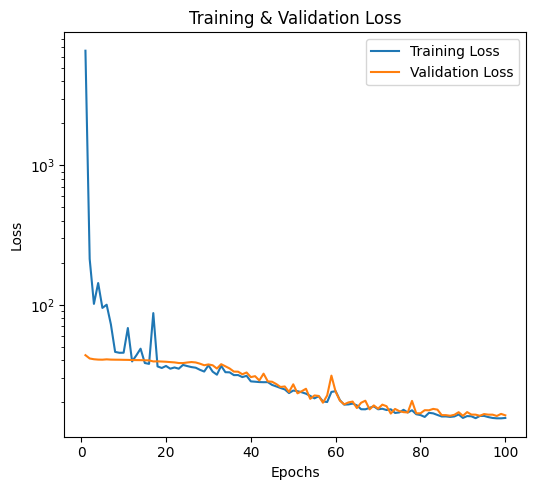

In [589]:
epochs = range(1, len(history.history['loss']) + 1)

plt.figure(figsize=(15, 5))

""" Loss """
plt.subplot(1, 3, 1) 
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

As we can see, the model is converging adequately, the loss is decreasing in a similar manner for both train and validation. We can be quite confident that the model is not overfitting.
As a small side-note, I would like to add that I represented the y axis in logarithmic scale because initially (for the first models I fit) the loss started with huge numbers. Thankfully, by tuning the model better this got fixed, but I already got used to the nice appearance of the log scale so I kept it. 

In [590]:
"""print('best parameters:', xyz.best_params_)
print('best score:', xyz.best_score_)"""

"print('best parameters:', xyz.best_params_)\nprint('best score:', xyz.best_score_)"

In [591]:
# best_mlp = xyz.best_estimator_

# best_mlp.fit(X, y_train)

X_test_preproc = pipeline_nn.transform(X_test)

y_pred_nn = NN_model.predict(X_test_preproc)
y_pred_trainn = NN_model.predict(X)

523/523 [==============================] - 0s 372us/step


These scores below have to be taken with a big pinch of salt because they come from the training set so the RMSE for example is hugely optimistic. The real test is on the test set but I don't have it so I can't really see the real scores until i submit to Kaggle.

In [592]:
print('SCORES OF MODEL ON TRAINING DATA\n')
print('R2:', r2_score(y, y_pred_trainn))
print('MSE:', mean_squared_error(y, y_pred_trainn))
print('MAE:', mean_absolute_error(y, y_pred_trainn))
print('Median AE:', median_absolute_error(y, y_pred_trainn))
print('RMSE:', mean_squared_error(y, y_pred_trainn, squared = False))

SCORES OF MODEL ON TRAINING DATA

R2: 0.4765842307271494
MSE: 13.603409477879666
MAE: 1.9578035861185186
Median AE: 1.0282289855957032
RMSE: 3.6882800161972065


/Users/guillemmirabentrubinat/.pyenv/versions/3.11.6/envs/neuralnets/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [593]:
nn_test = final_output_df.copy()

nn_test['LOS'] = y_pred_nn

kaggle_submit_nn = nn_test[['icustay_id', 'LOS']]
display(kaggle_submit_nn)

,icustay_id,LOS
0,208169,2.990072
1,251754,8.394031
2,242171,4.378669
3,263035,2.205704
4,279388,4.526090
...,...,...
5216,278087,9.174005
5217,266914,8.323576
5218,213413,1.185036
5219,286384,2.568571


In [594]:
kaggle_submit_nn.to_csv(f"{datetime.now().strftime('%Y%m%d_%H.%M')}_NN_GMR.csv", index = False)

[Back to Index](#index)

## ENSEMBLE PIPELINE

[Back to Index](#index)

I tried this ensemble model first and with default parameters it worked pretty well. I tried afterwards to improve it by setting some parameters to try to capture different things (for example in the rf I set the criterion to "absolute_error" insted of the default "squared_error" which I left for the xgb model). 

As the results suggested that the models might be heavily correlated, specially ElasticNet and Random Forest with a couple of other models, I tried to change them for a LASSO model to see if the correlation map goes down a bit and they really capture different trends. That being said, SVM and KNN are performing clearly worse than the rest so maybe after another run I'll decide to try and take them out as well.

The results you can see below from the last run of the cells come from the latest model I tried and the one I decided to keep. It contains SVM, KNN, RF, XGB and LASSO. The correlations between the models are not too high either, which signals that the models might be capturing different trends, which is what I wanted to get. Also setting RF criterion to 'poisson' seems to have helped lower its correlation with some other models, while implementing a LASSO instead of an ElasticNet also seems to have helped. This is probably due to the fact that the LASSO brings some coefficients to exact zero, which might help implement a feature selection trend for the meta learner to learn from.

Afterwards I decided to try to also add a Ridge model with a reduced alpha so that it resembles a linear regression a little bit more. The results in Kaggle were really good, better than all the other neural networks even.

I tried to add the models into the pipeline in a way that I could grid_search over their hyperparameters but I wasn't able to find it. In the end I just tried to optimize manually the fact that the models should be picking up different patterns (I guided my decisions with the correlations matrix and the final scores) but at the same time be good when used together in the meta_learner.

In [ ]:
np.int = np.int64

def model_init():
    svr = SVR(  shrinking=True,
                C=1.0,
                kernel='rbf',
                gamma='scale'
            )
    knn = KNeighborsRegressor(  algorithm='brute',
                                metric='minkowski',
                                weights='distance',
                                n_neighbors=300,
                                p=2,
                                n_jobs=-1
                            )
    rf = RandomForestRegressor( n_estimators=500,
                                criterion='poisson',
                                max_depth=50,
                                max_features='log2',
                                n_jobs=-1
                            )
    xgb = GradientBoostingRegressor(n_estimators=300,
                                    loss='squared_error',
                                    max_depth=5,
                                    criterion='friedman_mse',
                                    max_features='sqrt'
                                )
    """en = ElasticNet(alpha=1.0,
                    l1_ratio=0.5,
                    selection='cyclic',
                    tol=1e-3
                )"""
    las = Lasso(alpha=1.0,
                selection='random',
                tol=1e-4
            )
    rid = Ridge(alpha=0.5,
                solver='auto'
            )
    
    models =   {'svm': svr,
                'knn': knn,
                'rf': rf,
                'xgb': xgb,
                # 'en': en
                'las': las,
                'rid': rid
            }
    
    return models

def train_predict(xtrain, ytrain, xtest):
    models = model_init()
    preds = np.zeros((xtest.shape[0], len(models)))
    preds = pd.DataFrame(preds)
    
    cols = []
    for i, (name, model) in enumerate(models.items()):
        model.fit(xtrain, ytrain)
        preds.iloc[:, i] = model.predict(xtest)
        cols.append(name)
    
    preds.columns = cols
    return preds

def score_models(pred, ytrue):
    print("Scoring models.")
    scores=[]
    for m in pred.columns:
        score = mean_squared_error(ytrue, pred.loc[:, m])
        scores.append(score)
        print("%-26s: %.3f" % (m, score))
    return pred.columns,scores

In [ ]:
models_list = model_init()
P = train_predict(X, y, X_valid)
models, scores = score_models(P, y_valid)

Scoring models.
svm                       : 22.840
knn                       : 23.622
rf                        : 19.140
xgb                       : 17.582
las                       : 23.372
rid                       : 18.444


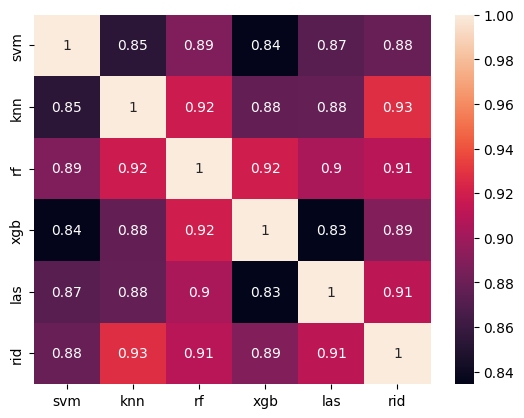

In [ ]:
sns.heatmap(P.corr(), annot=True)
plt.show()

We can see that there are a couple of high correlations which suggest that maybe I should change the random forest model for another one. Probably should delete or change the elastic net as well as it doesn't seem to capture radically different things. The idea was that maybe a linear regression type of model would be interesting to have there.

After a second run with LASSO and without ElasticNet and RF we can see how the correlations went down a bit so it might be a good sign.

That being said, after submitting the predictions to Kaggle for both runs, this second one appears to be slightly worse. The correlation might be an indicator of the fact that models are working correctly in that case. Next I'll try a run adding an RF but using the "weird" scoring metrics that are more rarely used.

Again we can see that the scores went down again (for the better, as I'm referring to the ordinary MSE, not the negative one from Grid Search) and this drove correlation up again. The model that's the least correlated with the rest is SVM, which is clearly the worst performing one as well. That being said, on Kaggle the score went up slightly.

As a result of all of this. I decided to leave this model with SVM, KNN, RF, XGB and LASSO version as it is one of the versions which highlight the added value of the ensemble the most while still maintaining one of the best scores for the ensemble models I tried. This is probably due to the fact that having more models helps the stacking regressor have more options to train from. Also the correlations for this last version are not too high so I'm happy about it.

Actually I also decided to try to add another model. I went with the same combination but I added LASSO with the normal alpha and also Ridge with a reduced alpha so that it resembles a linear regression more and I have both sides, which will clearly capture different aspects of the linear regression. The correlations are still not high even when having 6 different models, which I'm really happy about.

In [ ]:
Avg_pred = pd.DataFrame(P.mean(axis=1), columns=['Avg'])
models2, scores2 = score_models(Avg_pred, y_valid)

Scoring models.
Avg                       : 19.482


In [ ]:
meta_learner = ExtraTreesRegressor(
    n_estimators=1000,
    max_features='sqrt',
    bootstrap=True
)

sl = SuperLearner(
    folds=5,
    verbose=2,
    n_jobs=-1
)

sl.add(list(models_list.values()))
sl.add_meta(meta_learner)

sl.fit(X, y)

y_pred_sl = sl.predict(X_valid)

scores3 = mean_squared_error(y_valid, y_pred_sl)
print(f"Mean Squared Error SuperLearner: {scores3}")


Fitting 2 layers
Processing layer-1             done | 00:00:43
Processing layer-2             done | 00:00:10
Fit complete                        | 00:00:55

Predicting 2 layers
Processing layer-1             done | 00:00:06
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:08
Mean Squared Error SuperLearner: 16.834682184485974


The difference of the averaged score with respect to the SuperLearner score is quite noticeable here so it is a good sign of the relevance of the metalearner in this case with respect to the first run.

In [ ]:
X = X_ens
y = y_ens
X_test = X_test_ens

I really tried to use mlens SuperLearning into the sklearn pipeline but in the end I wasn't able to get it inside of it and working correctly. I ended up proceeding with the implementation using sklearn ensemble tool, Stacking Regressor.

In [ ]:
"""class SuperMan(BaseEstimator, RegressorMixin):
    def __init__(self, model_params=None, meta_learner=ExtraTreesRegressor()):
        self.model_params = model_params if model_params is not None else {}
        self.meta_learner = meta_learner

    def fit(self, X, y):
        self.sl = SuperLearner(folds=5, 
                                verbose=0,
                                n_jobs=-1
                                )
        
        models = model_init()
        for name, model in models.items():
            params = self.model_params.get(name, {})
            model.set_params(**params)
            self.sl.add([model], name=name)
        
        self.sl.add_meta(self.meta_learner)
        
        self.sl.fit(X, y)
        return self
    
    def predict(self, X):
        return self.sl.predict(X)"""

class SuperMan(BaseEstimator, RegressorMixin):
    def __init__(self, base_models=None, meta_learner=ExtraTreesRegressor()):
        self.base_models = base_models if base_models is not None else model_init()
        self.meta_learner = meta_learner
        self.sl = None

    def fit(self, X, y):
        self.sl = SuperLearner(folds=5,
                                verbose=2,
                                n_jobs=-1)
        self.sl.add(list(self.base_models.values()))
        self.sl.add_meta(self.meta_learner)
        self.sl.fit(X, y)
        return self

    def predict(self, X):
        return self.sl.predict(X)

In [ ]:
"""
PIPELINE FOR ENSEMBLE MODEL

I use 3 columns to be joined in the column transformer. I have columns for skewed and non-skewed variables but also for the categorical variables
that arised from the icd9 codes. I will use target encoding only on them so we also have a separate columnm for those 39 columns.
After that, we apply knn imputing to all of them and send everything into the knn classifier.
"""

skew_optimus_prime = Pipeline(
    steps = [
        ("arbusto", RobustScaler())
    ]
)

non_skew_megatron = Pipeline(
    steps = [
        ("escalador", StandardScaler())
    ]
)

cat_bumblebee = Pipeline(
    steps = [
        ("codex_iudicorum", MultiColumnTargetEncoder()),
        ("gat_escalador", StandardScaler())
    ]
)

pre_intel = ColumnTransformer(
    transformers = [
        ("skew", skew_optimus_prime, skew_cols),
        ("non_skew", non_skew_megatron, non_skew_cols),
        ("cat", cat_bumblebee, target_encoder_cols)
    ]
)

models_dict = model_init()
base_models = list(models_dict.items())
meta_learner = ExtraTreesRegressor(
                                    n_estimators=1000,
                                    max_features='sqrt',
                                    bootstrap=True,
                                    n_jobs=-1
                                )
stacking_regressor = StackingRegressor(
                                        estimators=base_models,
                                        final_estimator=meta_learner,
                                        n_jobs=-1
                                    )

pipeline_ens = Pipeline(
    steps = [
        ("preprocessing", pre_intel),
        ("imputer", KNNImputer()),
        ("selector", SelectKBest(f_classif)),
        ("classificatore", stacking_regressor)
    ]
)

param_grid_ens = {
    "preprocessing__cat__codex_iudicorum__smoothing": [5],#[1, 3, 5],
    "imputer__n_neighbors": [5],#[5, 10],
    "imputer__weights": ['uniform'],
    "selector__k": ['all']#[10, 'all'],
    # "classificatore__meta_learner__n_estimators": [100, 300, 500],
    # "classificatore__meta_learner__max_features": ['sqrt', 0.7],
    # "classificatore__meta_learner__bootstrap": [True]
}

GRID_ENS = GridSearchCV(pipeline_ens, param_grid=param_grid_ens, 
                        scoring='neg_mean_squared_error', 
                        cv=3, n_jobs=-1, verbose=3)

At this point I used the pipeline only to tweak the smoothing, the KNN imputer parameters and the selectKbest. 

For the n_estimators of the ExtraTreesRegressor, I started running the model with 100-200 estimators but I saw it was already running quite fast so I tried with a bigger amount and it did improve so I left it at 1000, which already takes quite a longer time to run, but it's still manageable and it performs noticeably better.

In [ ]:
np.int = np.int64

GRID_ENS.fit(X, y)

print("Best parameters:", GRID_ENS.best_params_)
print("Best score:", GRID_ENS.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 3/3] END imputer__n_neighbors=5, imputer__weights=uniform, preprocessing__cat__codex_iudicorum__smoothing=5, selector__k=all;, score=-18.128 total time= 2.7min
[CV 1/3] END imputer__n_neighbors=5, imputer__weights=uniform, preprocessing__cat__codex_iudicorum__smoothing=5, selector__k=all;, score=-16.636 total time= 2.7min
[CV 2/3] END imputer__n_neighbors=5, imputer__weights=uniform, preprocessing__cat__codex_iudicorum__smoothing=5, selector__k=all;, score=-17.514 total time= 2.7min
Best parameters: {'imputer__n_neighbors': 5, 'imputer__weights': 'uniform', 'preprocessing__cat__codex_iudicorum__smoothing': 5, 'selector__k': 'all'}
Best score: -17.426149428939514


In [ ]:
best_ens = GRID_ENS.best_estimator_

""" PICKLE SAVE """
# with open(f'{datetime.now().strftime('%Y%m%d_%H.%M')}_grid_MLP_model.pkl', 'wb') as file:
#     pickle.dump(GRID_MLP.best_estimator_, file)

best_ens.fit(X, y)

y_pred_ens = best_ens.predict(X_test)
y_pred_train = best_ens.predict(X)

In [ ]:
print('SCORES OF MODEL ON TRAINING DATA')
print('R2:', r2_score(y, y_pred_train))
print('MSE:', mean_squared_error(y, y_pred_train))
print('MAE:', mean_absolute_error(y, y_pred_train))
print('Median AE:', median_absolute_error(y, y_pred_train))
print('RMSE:', mean_squared_error(y, y_pred_train, squared = False))

SCORES OF MODEL ON TRAINING DATA
R2: 0.594997469174457
MSE: 10.848725124866343
MAE: 1.4893909293703604
Median AE: 0.647294000000004
RMSE: 3.293740294083057


/Users/guillemmirabentrubinat/.pyenv/versions/3.11.6/envs/neuralnets/lib/python3.11/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


PAST SCORES OF BEST MODELS ON TRAINING DATA

R2: 0.6214383428128658

MSE: 10.140458513347355

MAE: 1.4309420316303558

Median AE: 0.6278853999999994

RMSE: 3.1844086599158965

.

R2: 0.6938174422074381

MSE: 8.201653458187506

MAE: 1.2676097283504904

Median AE: 0.5654761000000008

RMSE: 2.863852904425698

In [ ]:
""" PICKLE LOAD """

# with open(f'./cogombrets/< specify date here >_grid_MLP_model.pkl', 'rb') as file:
#     loaded_grid_search = pickle.load(file)

' PICKLE LOAD '

In [ ]:
ens_test = final_output_df.copy()

ens_test['LOS'] = y_pred_ens

kaggle_submit_ens = ens_test[['icustay_id', 'LOS']]
display(kaggle_submit_ens)

,icustay_id,LOS
0,208169,3.653245
1,251754,10.429578
2,242171,4.000036
3,263035,2.828618
4,279388,6.928563
...,...,...
5216,278087,7.716169
5217,266914,7.910420
5218,213413,1.660414
5219,286384,2.172912


In [ ]:
kaggle_submit_ens.to_csv(f"{datetime.now().strftime('%Y%m%d_%H.%M')}_ENSMBL_GMR.csv", index = False)

[Back to Index](#index)